<a href="https://colab.research.google.com/github/mtareqsoliman/msthesis/blob/main/Benchmark_RS_ANN_12022022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. BENCHMARK**



In [46]:
import pandas as pd
import numpy as np
import math as math
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from matplotlib.gridspec import GridSpec
import scipy.stats as sp
from scipy.optimize import minimize, LinearConstraint
import scipy.optimize as spo
from matplotlib.colors import LinearSegmentedColormap
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from scipy.interpolate import make_interp_spline

np.seterr(divide='ignore')


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [62]:

#NLTHA100 = pd.read_excel('https://github.com/mtareqsoliman/msthesis/blob/main/Results/100NLTHA_FINAL.xlsx?raw=true')
NLTHA100 = pd.read_excel('https://github.com/mtareqsoliman/msthesis/blob/main/Results/NLTHA100_v2.xlsx?raw=true')
                          # ln(x)                                mean(ln(x))                                  stdev(ln(x))
from sklearn.preprocessing import StandardScaler
ecu_9600_alpha = StandardScaler().fit_transform(np.log(-NLTHA100[['ecu']]))
Vult_9600_alpha = StandardScaler().fit_transform(np.log(NLTHA100[['Vult']]))

print(ecu_9600_alpha.mean())
print(ecu_9600_alpha.std())

#ecu_9600_alpha = norm.cdf(np.log(-np.array(NLTHA100[['ecu']])), np.log(-np.array(NLTHA100[['ecu']])).mean(), np.log(-np.array(NLTHA100[['ecu']])).std())
#Vult_9600_alpha = norm.cdf(np.log(np.array(NLTHA100[['Vult']])), np.log(np.array(NLTHA100[['Vult']])).mean(),  np.log(np.array(NLTHA100[['Vult']])).std())

#ecu_9600_alpha, Vult_9600_alpha = norm.ppf(ecu_9600_alpha,0,1) , norm.ppf(Vult_9600_alpha,0,1)

NLTHA100.insert(2,'ecu_alpha',ecu_9600_alpha)
NLTHA100.insert(3,'Vult_alpha',Vult_9600_alpha)

del ecu_9600_alpha, Vult_9600_alpha

NLTHA100.head()

-4.963622105928304e-16
1.0000000000000002


,state,IM,ecu_alpha,Vult_alpha,record,ecu,Vult,Vbmax,ect,ecb,uindex,convergence
0,1,40,-0.078909,-1.003151,RSN126_GAZLI_GAZ000,-0.005924,136.937169,149.292866,-0.059747,-0.127637,906,0
1,1,40,0.647897,-0.512844,RSN126_GAZLI_GAZ000,-0.007727,151.480457,158.735679,-0.006355,-0.116928,1100,0
2,1,40,2.184076,0.740175,RSN126_GAZLI_GAZ000,-0.013546,196.056429,168.429786,-0.004334,-0.018871,1677,0
3,1,40,1.069093,0.463563,RSN126_GAZLI_GAZ000,-0.009012,185.204250,163.410309,-0.006168,-0.115032,1111,0
4,1,40,-1.513915,-0.582628,RSN126_GAZLI_GAZ000,-0.003507,149.319891,142.350730,-0.100692,-0.121525,913,0


In [63]:
NLTHA100_pivot = pd.pivot_table(NLTHA100, values='state', index=['ecu_alpha','Vult_alpha'],columns=['IM'], aggfunc=np.sum)  #merging rows makes more problems so leave them as they are
NLTHA100_pivot.insert(0,0,0)

NLTHA100_pivot

,IM,0,5,10,15,20,25,30,35,40
ecu_alpha,Vult_alpha,,,,,,,,,
-2.482571,0.951976,0,0,4,8,11,12,12,12,12
-2.030793,-1.018160,0,0,4,8,11,12,12,12,12
-1.945112,-0.238823,0,0,3,7,10,12,12,12,12
-1.944940,-0.865400,0,0,3,7,10,12,12,12,12
-1.777137,1.575365,0,0,3,7,10,12,12,12,12
...,...,...,...,...,...,...,...,...,...,...
1.773630,0.365622,0,0,0,0,0,3,7,8,10
1.962449,-0.981664,0,0,3,8,11,12,12,12,12
2.184076,0.740175,0,0,0,0,0,0,3,7,9


In [80]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

ecu_100_alpha_frag, Vult_100_alpha_frag = zip(*NLTHA100_pivot.index.values)
ecu_100_alpha_frag, Vult_100_alpha_frag = np.asarray(ecu_100_alpha_frag), np.asarray(Vult_100_alpha_frag)

lambda_100_list = []
zeta_100_list = []
z_100_list = []

IM = np.arange(0,45,5)
fragility_table_100 = pd.DataFrame(columns = ['0','5','10','15','20','25','30','35','40'])

def frag(lambdazeta):
    estimated_fragility = sp.norm.cdf(np.log(factor_list),np.log(lambdazeta[0]),lambdazeta[1])
    log_likelihood = np.log(sp.binom.pmf(ncllps_NLTHA100_i,nrcrds,estimated_fragility))
    fun = -np.sum(log_likelihood)

    return fun

for i,ecu_i in enumerate(ecu_100_alpha_frag):
    factor_list = np.array([0,5,10,15,20,25,30,35,40])
    ncllps_NLTHA100_i = NLTHA100_pivot.iloc[i]
    nrcrds = 12

    # starting guess
    lambdazeta_start = [24,0.4]

    # Bounds
    bnds = ((4, 50), (0.2, 1))
    
    result = spo.minimize(frag,lambdazeta_start,options={'disp': True},bounds=bnds)

    if result.success:
        miny = result.x
        lambda_mxlk = round(miny[0],2)
        zeta_mxlk = round(miny[1],2)
        lambda_100_list.append(lambda_mxlk)
        zeta_100_list.append(zeta_mxlk)

        z_mxlk = -round(result.fun,2)
        z_100_list.append(z_mxlk)
        fragility_table_100.loc[i] = sp.norm.cdf(np.log(IM),np.log(lambda_mxlk),zeta_mxlk)

    else:
        print("Failed!", end = '\n')
        break

fragility_table_100

,0,5,10,15,20,25,30,35,40
0,0.0,4.382175e-03,2.801339e-01,0.729102,0.927335,0.982679,0.995961,0.999039,0.999763
1,0.0,4.382175e-03,2.801339e-01,0.729102,0.927335,0.982679,0.995961,0.999039,0.999763
2,0.0,1.976744e-03,1.995636e-01,0.636592,0.884052,0.967972,0.991531,0.997754,0.999390
3,0.0,1.976744e-03,1.995636e-01,0.636592,0.884052,0.967972,0.991531,0.997754,0.999390
4,0.0,1.976744e-03,1.995636e-01,0.636592,0.884052,0.967972,0.991531,0.997754,0.999390
...,...,...,...,...,...,...,...,...,...
95,0.0,2.428903e-13,4.162906e-06,0.002293,0.046087,0.214336,0.475209,0.710355,0.861823
96,0.0,1.330352e-03,2.211007e-01,0.705219,0.928877,0.985640,0.997244,0.999467,0.999894
97,0.0,1.696356e-22,2.450944e-10,0.000014,0.002921,0.050424,0.232954,0.516592,0.760918
98,0.0,1.696356e-22,2.450944e-10,0.000014,0.002921,0.050424,0.232954,0.516592,0.760918


Median

In [64]:
NLTHA100_pivot.median()

IM
0      0.0
5      0.0
10     1.0
15     4.0
20     7.0
25    10.5
30    11.0
35    12.0
40    12.0
dtype: float64

In [65]:
 np.median(NLTHA100_pivot,axis=0)

array([ 0. ,  0. ,  1. ,  4. ,  7. , 10.5, 11. , 12. , 12. ])

Now we will draw the histogram for IM=20cm/sec

Success!


<ipython-input-6-8ae95a5f0b8f>:6: RuntimeWarning: divide by zero encountered in log
  estimated_fragility = sp.norm.cdf(np.log(factor_list),np.log(lambdazeta[0]),lambdazeta[1])
<ipython-input-6-8ae95a5f0b8f>:32: RuntimeWarning: divide by zero encountered in log
  NLTHA100_frag = sp.norm.cdf(np.log(np.linspace(0,40,100)),np.log(NLTHA100_lz[0]),NLTHA100_lz[1])


IM
0     0.000000
5     0.000000
10    0.083333
15    0.333333
20    0.583333
25    0.875000
30    0.916667
35    1.000000
40    1.000000
dtype: float64

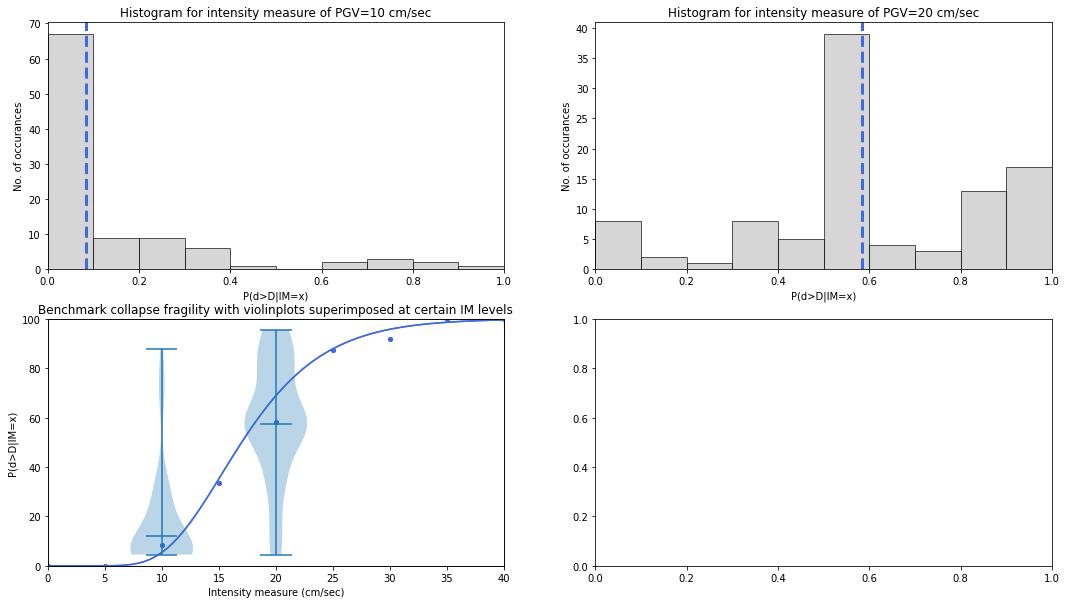

In [6]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

def frag(lambdazeta):
  estimated_fragility = sp.norm.cdf(np.log(factor_list),np.log(lambdazeta[0]),lambdazeta[1])
  log_likelihood = sp.binom.pmf(ncllps_bmark,nrcrds,estimated_fragility)
  fun = -np.sum(log_likelihood)

  return fun
factor_list = np.array([0,5,10,15,20,25,30,35,40])
nrcrds = 12
ncllps_bmark = np.median(NLTHA100_pivot,axis=0)
#pcllps =  ncllps_bmark/nrcrds

# starting guess
lambdazeta_start = [24,0.4]

# Bounds
bnds = ((4, 50), (0.2, 5))

result = spo.minimize(frag,lambdazeta_start,options={'disp': True},bounds=bnds)

if result.success:
    print("Success!", end = '\n')
    miny = result.x
    lambda_mxlk_bmark = round(miny[0],2)
    zeta_mxlk_bmark = round(miny[1],2)
    z_mxlk_bmark = -round(result.fun,2)

NLTHA100_lz = [lambda_mxlk_bmark,zeta_mxlk_bmark,z_mxlk_bmark]
NLTHA100_frag = sp.norm.cdf(np.log(np.linspace(0,40,100)),np.log(NLTHA100_lz[0]),NLTHA100_lz[1])

fig, ax = plt.subplots(nrows=2,ncols=2,figsize =(18,10))
for y,sel_IM in zip([0,1],[10,20]):

  ax[0,y].hist(NLTHA100_pivot[sel_IM]/12,color='silver', edgecolor='k', alpha=0.65,bins=np.arange(min(NLTHA100_pivot[sel_IM]/12), max(NLTHA100_pivot[sel_IM]/12) + 0.1, 0.1))
  ax[0,y].set_xlim(0,1)
  ax[0,y].set_ylim(0)
  ax[0,y].set_xlabel('P(d>D|IM=x)')
  ax[0,y].set_ylabel('No. of occurances')   
  ax[0,y].set_title('Histogram for intensity measure of PGV='+str(sel_IM)+' cm/sec')  
  ax[0,y].axvline(np.median(NLTHA100_pivot[sel_IM]/12,axis=0),color='royalblue', linestyle='dashed', linewidth=3)
  #ax2 = ax[1,0].twinx()  # instantiate a second axes that shares the same x-axis
  #ax2.tick_params(axis='y')
  #ax2.violinplot(NLTHA100_pivot[sel_IM]/12,positions=[sel_IM],widths=5.5)
  ax[1,0].set_xlim(0,40)
  ax[1,0].set_ylim(0,100)
  ax[1,0].plot(np.linspace(0,40,100),NLTHA100_frag*100,linestyle='-',color='royalblue')
  ax[1,0].scatter(np.arange(0,45,5),np.median(NLTHA100_pivot,axis=0)*100/12,s=15,color='royalblue')
  ax[1,0].set_xlabel('Intensity measure (cm/sec)')
  ax[1,0].set_ylabel('P(d>D|IM=x)')
  ax[1,0].set_title('Benchmark collapse fragility with violinplots superimposed at certain IM levels')

        # 100 points of x,    interpolation for the curve,                                                              clearing non-zeroes

del sel_IM,y

#do not forget to make the straight line between 0 and 5

ax2 = ax[1,0].twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_yticks([])
ax2.violinplot(NLTHA100_pivot[[10,20]].values,positions=[10,20],widths=5.5,showmedians=True)

NLTHA100_pivot.median()/12

# **2. RESPONSE SURFACE**

In [7]:
NLTHA9 = pd.read_excel('https://github.com/mtareqsoliman/msthesis/blob/main/Results/9NLTHA_FINAL.xlsx?raw=true',index_col=0)
NLTHA9

,state,IM,record,ecu_alpha,Vult_alpha,ecu,Vult,Vbmax,ect,ecb,uindex,convergence
index,,,,,,,,,,,,
0,1,40,RSN126_GAZLI_GAZ000,-1.414214,0.000000,-0.003667,174.4819,142.824246,-0.058941,-0.112813,914,0
1,1,40,RSN126_GAZLI_GAZ000,-1.000000,-1.000000,-0.004356,137.1152,144.838821,-0.026165,-0.099632,906,FAILED
2,1,40,RSN126_GAZLI_GAZ000,-1.000000,1.000000,-0.004356,205.5083,144.838821,-0.026165,-0.099632,951,FAILED
3,1,40,RSN126_GAZLI_GAZ000,0.000000,-1.414214,-0.006019,121.6374,150.235062,-0.058990,-0.126897,855,0
4,1,40,RSN126_GAZLI_GAZ000,0.000000,0.000000,-0.006019,174.4819,150.235062,-0.058990,-0.126897,956,0
...,...,...,...,...,...,...,...,...,...,...,...,...
859,0,5,RSN1605_DUZCE_DZC270,0.000000,0.000000,-0.006019,174.4819,59.236274,-0.000406,-0.000677,0,0
860,0,5,RSN1605_DUZCE_DZC270,0.000000,1.414214,-0.006019,218.3598,59.236274,-0.000406,-0.000677,0,0
861,0,5,RSN1605_DUZCE_DZC270,1.000000,-1.000000,-0.008243,137.1152,56.116504,-0.000404,-0.000672,0,0


In [8]:
NLTHA9_pivot = pd.pivot_table(NLTHA9, values='state', index=['ecu_alpha','Vult_alpha'],columns=['IM'], aggfunc=np.sum)  #merging rows makes more problems so leave them as they are
NLTHA9_pivot.insert(0,0,0)

NLTHA9_pivot

IM                    0   5   10  15  20  25  30  35  40
ecu_alpha Vult_alpha                                    
-1.414214  0.000000    0   0   2   6  10  11  12  12  12
-1.000000 -1.000000    0   0   4   8  11  12  12  12  12
           1.000000    0   0   2   5   7  11  12  12  12
 0.000000 -1.414214    0   3   8  12  12  12  12  12  12
           0.000000    0   0   0   4   7  10  11  12  12
           1.414214    0   0   0   4   7  10  11  12  12
 1.000000 -1.000000    0   0   4   8  11  12  12  12  12
           1.000000    0   0   0   1   4   8  10  10  11
 1.414214  0.000000    0   0   0   0   2   6   9  10  11

In [9]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

ecu_9_alpha_frag, Vult_9_alpha_frag = zip(*NLTHA9_pivot.index.values)
ecu_9_alpha_frag, Vult_9_alpha_frag = np.asarray(ecu_9_alpha_frag), np.asarray(Vult_9_alpha_frag)

lambda_9_list = []
zeta_9_list = []
z_9_list = []

IM = np.arange(0,45,5)
fragility_table_9CCM = pd.DataFrame(columns = ['0','5','10','15','20','25','30','35','40'])

def frag(lambdazeta):
    estimated_fragility = sp.norm.cdf(np.log(factor_list),np.log(lambdazeta[0]),lambdazeta[1])
    log_likelihood = np.log(sp.binom.pmf(ncllps_CCM9_i,nrcrds,estimated_fragility))
    fun = -np.sum(log_likelihood)

    return fun

for i,ecu_i in enumerate(ecu_9_alpha_frag[0:9]):
    factor_list = np.array([0,5,10,15,20,25,30,35,40])
    ncllps_CCM9_i = NLTHA9_pivot.iloc[i]
    nrcrds = 12

    # starting guess
    lambdazeta_start = [24,0.4]

    # Bounds
    bnds = ((4, 50), (0.2, 1))
    
    result = spo.minimize(frag,lambdazeta_start,options={'disp': True},bounds=bnds)

    if result.success:
        print("Success!", end = '\n')
        miny = result.x
        lambda_mxlk = round(miny[0],2)
        zeta_mxlk = round(miny[1],2)
        lambda_9_list.append(lambda_mxlk)
        zeta_9_list.append(zeta_mxlk)

        z_mxlk = -round(result.fun,2)
        z_9_list.append(z_mxlk)

    else:
        print("Failed!", end = '\n')
        miny = result.x
        lambda_mxlk = round(miny[0],2)
        zeta_mxlk = round(miny[1],2)
        lambda_9_list.append(lambda_mxlk)
        zeta_9_list.append(zeta_mxlk)

        z_mxlk = -round(result.fun,2)
        z_9_list.append(z_mxlk)
        #fragility_table_9CCM.loc[i] = np.ceil(sp.norm.cdf(np.log(IM),np.log(lambda_mxlk),zeta_mxlk)*12)


<ipython-input-9-d15ec9a1950e>:16: RuntimeWarning: divide by zero encountered in log
  estimated_fragility = sp.norm.cdf(np.log(factor_list),np.log(lambdazeta[0]),lambdazeta[1])


Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!
Success!


[[ 0.          0.15026941  0.279746    0.03415156  0.09449024 -0.22978552]
 [ 0.         -0.01362437 -0.01923097  0.005625   -0.0025      0.035625  ]]
[[ 5.03069808e-17  3.14967480e-02  7.52556742e-02  3.41515589e-02
   9.44902440e-02 -2.29785522e-01  8.72759132e-02  2.12766930e-02
  -2.42824172e-02  1.29234655e-01]
 [-1.38777878e-17 -8.33333337e-04  2.49999999e-03  5.62500000e-03
  -2.50000000e-03  3.56250000e-02 -1.19577020e-02  2.92309704e-02
   1.02910353e-02 -2.42309704e-02]]


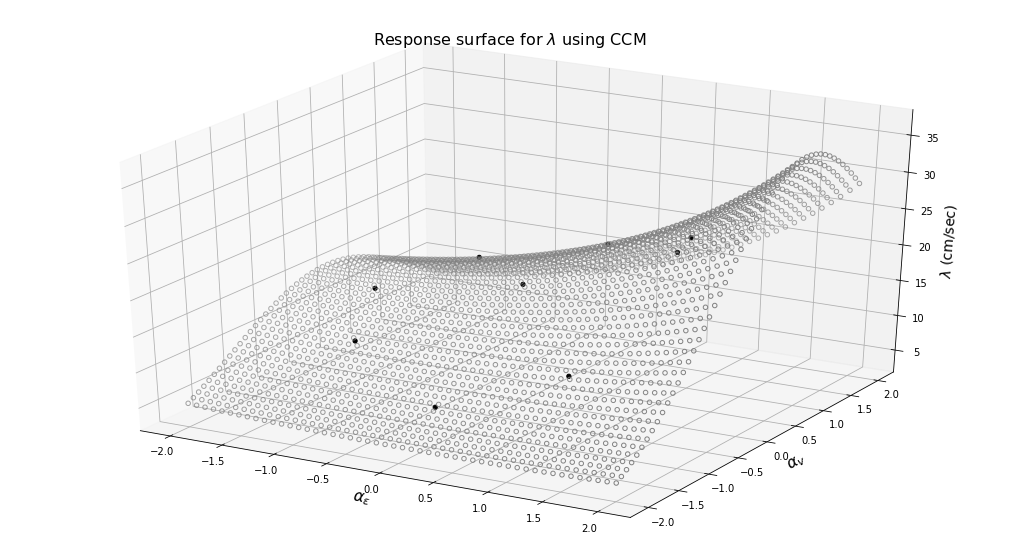

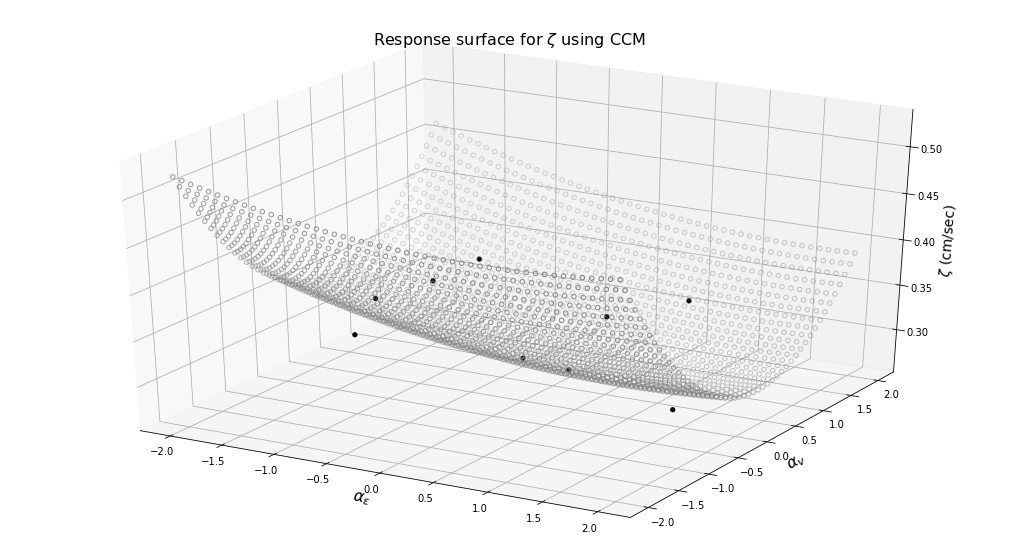

In [10]:
from sklearn.preprocessing import StandardScaler
 

x1_CCM9,x2_CCM9 = map(list,zip(*NLTHA9_pivot.index.values))

x_CCM9 =np.column_stack((x1_CCM9,x2_CCM9))
y_CCM9 = np.column_stack((np.log(lambda_9_list),zeta_9_list))

################ 2nd degree
deg2_polymodel = PolynomialFeatures(degree=2)
x_poly_CCM9_deg2 = deg2_polymodel.fit_transform(x_CCM9)

# should be in the form [1, a, b, a^2, ab, b^2]
deg2_polymodel.fit(x_poly_CCM9_deg2, y_CCM9)
deg2_CCM9_regmodel = LinearRegression()
deg2_CCM9_regmodel.fit(x_poly_CCM9_deg2, y_CCM9)

y_pred_deg2 = deg2_CCM9_regmodel.predict(x_poly_CCM9_deg2)
print(deg2_CCM9_regmodel.coef_)
#p00,p10,p01,p20,p11,p02 = deg2_CCM9_regmodel.coef_.T
MSE = mean_squared_error(y_CCM9, y_pred_deg2, squared=False)

x1_mesh,x2_mesh = np.linspace(-2, 2, 50), np.linspace(-2, 2, 50)
x1_mesh, x2_mesh = np.meshgrid(x1_mesh, x2_mesh)
x_mesh = np.array([x1_mesh.flatten(), x2_mesh.flatten()]).T
poly_x_mesh = deg2_polymodel.fit_transform(x_mesh)
y_mesh_deg2 = deg2_CCM9_regmodel.predict(poly_x_mesh)

################ 3rd degree 
deg3_polymodel = PolynomialFeatures(degree=3)
x_poly_CCM9_deg3 = deg3_polymodel.fit_transform(x_CCM9)

# should be in the form []
deg3_polymodel.fit(x_poly_CCM9_deg3, y_CCM9)
deg3_CCM9_regmodel = LinearRegression()
deg3_CCM9_regmodel.fit(x_poly_CCM9_deg3, y_CCM9)
y_pred_deg3 = deg3_CCM9_regmodel.predict(x_poly_CCM9_deg3)
print(deg3_CCM9_regmodel.coef_)
#p00,p10,p01,p20,p11,p02 = deg3_CCM9_regmodel.coef_.T
MSE = mean_squared_error(y_CCM9, y_pred_deg3, squared=False)

x1_mesh,x2_mesh = np.linspace(-2, 2, 50), np.linspace(-2, 2, 50)
x1_mesh, x2_mesh = np.meshgrid(x1_mesh, x2_mesh)
x_mesh = np.array([x1_mesh.flatten(), x2_mesh.flatten()]).T
poly_x_mesh = deg3_polymodel.fit_transform(x_mesh)
y_mesh_deg3 = deg3_CCM9_regmodel.predict(poly_x_mesh)


fig, ax = plt.subplots(figsize =(18,10), subplot_kw={'projection': '3d'})
ax.set_zlabel(r"$\lambda$ (cm/sec)",fontsize=14)
ax.set_xlabel(r"$\alpha_\epsilon$",fontsize=16)
ax.set_ylabel(r"$\alpha_v$",fontsize=16)
ax.set_title(r"Response surface for $\lambda$ using CCM",fontsize=16)


ax.scatter(x_CCM9[:,0], x_CCM9[:,1], np.exp(y_CCM9[:,0]),color='black',marker='.',alpha=1,s=70)
ax.scatter(x1_mesh, x2_mesh, np.exp(y_mesh_deg2[:,0]), facecolor=(0,0,0,0), s=20, edgecolor='gray')

fig, ax = plt.subplots(figsize =(18,10), subplot_kw={'projection': '3d'})


ax.set_zlabel(r"$\zeta$ (cm/sec)",fontsize=14)
ax.set_xlabel(r"$\alpha_\epsilon$",fontsize=16)
ax.set_ylabel(r"$\alpha_v$",fontsize=16)
ax.set_title(r"Response surface for $\zeta$ using CCM",fontsize=16)


ax.scatter(x_CCM9[:,0], x_CCM9[:,1], y_CCM9[:,1],color='black',marker='.',alpha=1,s=70)
ax.scatter(x1_mesh, x2_mesh, y_mesh_deg2[:,1], facecolor=(0,0,0,0), s=20, edgecolor='gray')


# should be in the form [1, a, b, a^2, ab, b^2]

In [11]:
alpha_ecu_1000 = np.random.normal(0, 1, 1000)
alpha_Vult_1000 = np.random.normal(0, 1, 1000)

x_1000_CCM9 = np.array([alpha_ecu_1000, alpha_Vult_1000]).T
x_1000_poly_CCM9_deg2 = deg2_polymodel.fit_transform(x_1000_CCM9)
y_1000_CCM9_deg2 = deg2_CCM9_regmodel.predict(x_1000_poly_CCM9_deg2)
x_1000_poly_CCM9_deg3 = deg3_polymodel.fit_transform(x_1000_CCM9)
y_1000_CCM9_deg3 = deg3_CCM9_regmodel.predict(x_1000_poly_CCM9_deg3)


fragility_table_CCM9_1000_deg2 = pd.DataFrame(columns = ['0','5','10','15','20','25','30','35','40'])
fragility_table_CCM9_1000_deg3 = pd.DataFrame(columns = ['0','5','10','15','20','25','30','35','40'])

for i in np.arange(len(y_1000_CCM9_deg2)):
  fragility_table_CCM9_1000_deg2.loc[i] = sp.norm.cdf(np.log(IM),y_1000_CCM9_deg2[i,0],y_1000_CCM9_deg2[i,1])*12
for i in np.arange(len(y_1000_CCM9_deg3)):
  fragility_table_CCM9_1000_deg3.loc[i] = sp.norm.cdf(np.log(IM),y_1000_CCM9_deg3[i,0],y_1000_CCM9_deg3[i,1])*12


fragility_table_CCM9_1000_deg3

<ipython-input-11-491efc0d5467>:15: RuntimeWarning: divide by zero encountered in log
  fragility_table_CCM9_1000_deg2.loc[i] = sp.norm.cdf(np.log(IM),y_1000_CCM9_deg2[i,0],y_1000_CCM9_deg2[i,1])*12
<ipython-input-11-491efc0d5467>:17: RuntimeWarning: divide by zero encountered in log
  fragility_table_CCM9_1000_deg3.loc[i] = sp.norm.cdf(np.log(IM),y_1000_CCM9_deg3[i,0],y_1000_CCM9_deg3[i,1])*12


,0,5,10,15,20,25,30,35,40
0,0.0,5.471284e-25,7.513852e-10,2.986052e-04,0.106492,1.726317,6.025453,9.818892,11.455223
1,0.0,1.030587e+01,1.185146e+01,1.197964e+01,11.996178,11.999103,11.999752,11.999922,11.999973
2,0.0,4.696699e-46,5.370073e-20,8.778036e-10,0.000092,0.040739,0.995196,4.730325,9.094044
3,0.0,7.009507e-07,2.901590e-02,1.030348e+00,4.416129,8.133185,10.408200,11.425272,11.807566
4,0.0,3.729942e-02,2.795591e+00,8.061723e+00,10.792304,11.673889,11.914746,11.977487,11.993879
...,...,...,...,...,...,...,...,...,...
995,0.0,1.150456e-05,4.953724e-02,9.673230e-01,3.614705,6.771119,9.169190,10.598409,11.341943
996,0.0,1.003716e-06,3.098663e-03,8.755592e-02,0.521692,1.513236,2.971540,4.628691,6.232783
997,0.0,5.042084e-03,1.075656e+00,5.165034e+00,8.918146,10.829730,11.588229,11.858847,11.951611
998,0.0,3.407518e-03,9.495241e-01,4.953993e+00,8.806416,10.796403,11.583094,11.860004,11.953126


In [12]:
np.round(fragility_table_CCM9_1000_deg2.median())

0      0.0
5      0.0
10     1.0
15     4.0
20     9.0
25    11.0
30    12.0
35    12.0
40    12.0
dtype: float64

In [13]:
np.round(fragility_table_CCM9_1000_deg3.median())

0      0.0
5      0.0
10     0.0
15     4.0
20     8.0
25    11.0
30    12.0
35    12.0
40    12.0
dtype: float64

In [14]:
import math
def frag(lambdazeta):
    estimated_fragility = sp.norm.cdf(np.log(factor_list),np.log(lambdazeta[0]),lambdazeta[1])
    log_likelihood = np.log(sp.binom.pmf(ncllps_CCM1000_deg2,12,estimated_fragility))
    fun = -np.sum(log_likelihood)

    return fun

factor_list = np.array([0,5,10,15,20,25,30,35,40])
nrcrds = 12
ncllps_CCM1000_deg2 = np.round(fragility_table_CCM9_1000_deg2.median())
pcllps_CCM1000_deg2 = ncllps_CCM1000_deg2/12

# starting guess
lambdazeta_start = np.array([15,0.4])

# Bounds
bnds = ((4, 50), (0.2, 1))

result = spo.minimize(frag,lambdazeta_start,options={'disp': True},bounds=bnds)
CCM9_1000_lgnrml = []
if result.success:
    print("Success!", end = '\n')
    miny = result.x
    CCM9_1000_lambda = round(miny[0],2)
    CCM9_1000_zeta = round(miny[1],2)
    CCM9_1000_cost = -round(result.fun,2)

CCM9_1000_lz_deg2 = [CCM9_1000_lambda,CCM9_1000_zeta,CCM9_1000_cost]
CCM9_1000_lgnrml_deg2 = sp.norm.cdf(np.log(np.linspace(0,40,1000)),np.log(CCM9_1000_lz_deg2[0]),CCM9_1000_lz_deg2[1])

print(result)

Success!
      fun: 5.2242129628026195
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([9.76996181e-07, 4.44089210e-07])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 33
      nit: 8
     njev: 11
   status: 0
  success: True
        x: array([16.24976757,  0.29415302])


<ipython-input-14-5ac5aea761bc>:3: RuntimeWarning: divide by zero encountered in log
  estimated_fragility = sp.norm.cdf(np.log(factor_list),np.log(lambdazeta[0]),lambdazeta[1])
<ipython-input-14-5ac5aea761bc>:30: RuntimeWarning: divide by zero encountered in log
  CCM9_1000_lgnrml_deg2 = sp.norm.cdf(np.log(np.linspace(0,40,1000)),np.log(CCM9_1000_lz_deg2[0]),CCM9_1000_lz_deg2[1])


In [15]:
import math
def frag(lambdazeta):
    estimated_fragility = sp.norm.cdf(np.log(factor_list),np.log(lambdazeta[0]),lambdazeta[1])
    log_likelihood = np.log(sp.binom.pmf(ncllps_CCM1000_deg3,nrcrds,estimated_fragility))
    fun = -np.sum(log_likelihood)

    return fun

factor_list = np.array([0,5,10,15,20,25,30,35,40])
nrcrds = 12
ncllps_CCM1000_deg3 = np.round(fragility_table_CCM9_1000_deg3.median())
pcllps_CCM1000_deg3 = ncllps_CCM1000_deg3/12

# starting guess
lambdazeta_start = np.array([15,0.4])

# Bounds
bnds = ((4, 50), (0.2, 1))

result = spo.minimize(frag,lambdazeta_start,options={'disp': True},bounds=bnds)
CCM9_1000_lgnrml = []
if result.success:
    print("Success!", end = '\n')
    miny = result.x
    CCM9_1000_lambda_deg3 = round(miny[0],2)
    CCM9_1000_zeta_deg3 = round(miny[1],2)
    CCM9_1000_cost_deg3 = -round(result.fun,2)

CCM9_1000_lz_deg3 = [CCM9_1000_lambda_deg3,CCM9_1000_zeta_deg3,CCM9_1000_cost_deg3]
CCM9_1000_lgnrml_deg3 = sp.norm.cdf(np.log(np.linspace(0,40,1000)),np.log(CCM9_1000_lz_deg3[0]),CCM9_1000_lz_deg3[1])

print(result)

Success!
      fun: 4.3466138229181865
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.10542677e-07,  1.90070182e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 33
      nit: 9
     njev: 11
   status: 0
  success: True
        x: array([17.40325335,  0.24239235])


<ipython-input-15-124e4548667c>:3: RuntimeWarning: divide by zero encountered in log
  estimated_fragility = sp.norm.cdf(np.log(factor_list),np.log(lambdazeta[0]),lambdazeta[1])
<ipython-input-15-124e4548667c>:30: RuntimeWarning: divide by zero encountered in log
  CCM9_1000_lgnrml_deg3 = sp.norm.cdf(np.log(np.linspace(0,40,1000)),np.log(CCM9_1000_lz_deg3[0]),CCM9_1000_lz_deg3[1])


0     0.000000
5     0.000094
10    0.058199
15    0.374495
20    0.718788
25    0.897723
30    0.966535
35    0.989611
40    0.996797
dtype: float64

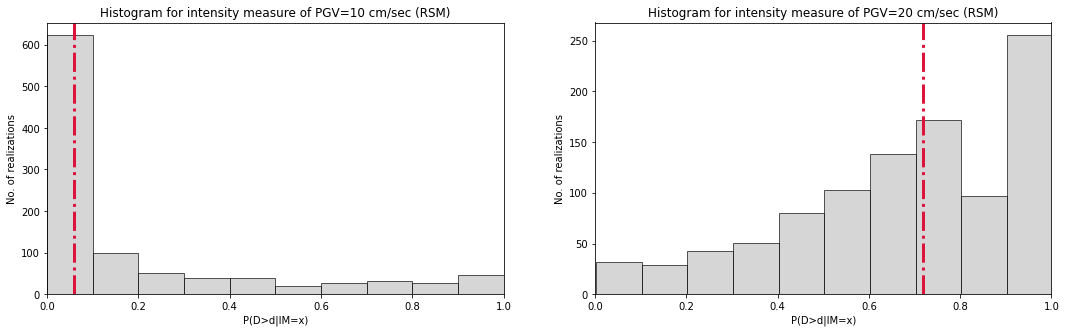

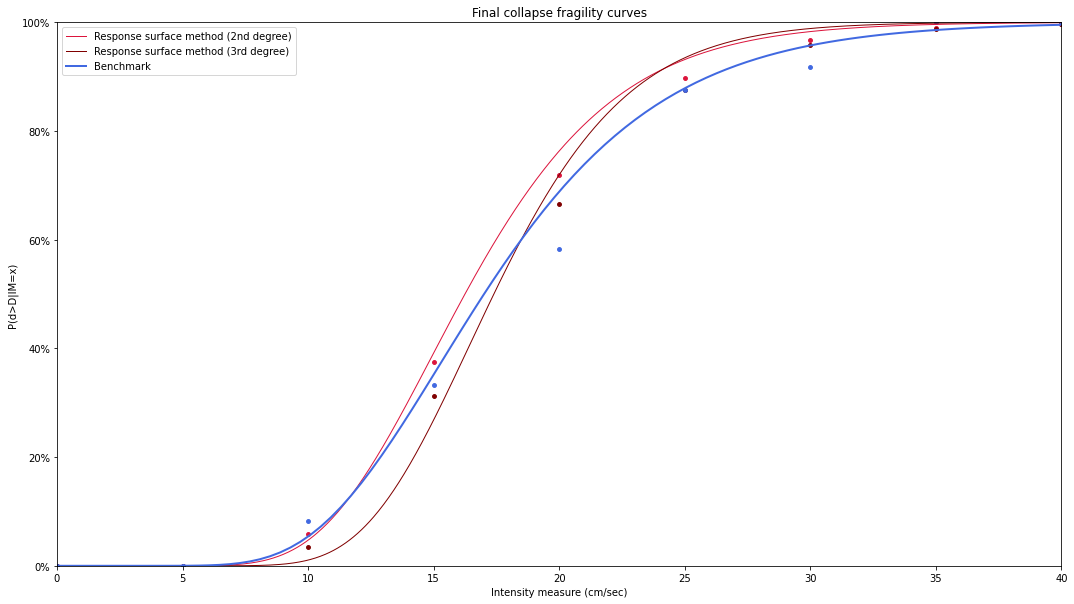

In [16]:
##from scipy.interpolate import interp1d
import matplotlib.ticker as mtick

#CCM9_1000_lz = fit_lognormal(np.median(fragility_table_CCM9_1000_deg2,axis=0))
#CCM9_1000_lgnrml = sp.norm.cdf(np.log(np.linspace(0,40,100)),np.log(CCM9_1000_lz[0]),CCM9_1000_lz[1])

fig, ax = plt.subplots(nrows=1,ncols=2,figsize =(18,5))

for y,sel_IM in zip([0,1],["10","20"]):
  ax[y].hist((fragility_table_CCM9_1000_deg2[sel_IM])/12,color='silver', edgecolor='k', alpha=0.65,bins=np.arange(min((fragility_table_CCM9_1000_deg2[sel_IM])/12), max((fragility_table_CCM9_1000_deg2[sel_IM])/12) + 0.1, 0.1))
  ax[y].set_xlim(0,1)
  ax[y].set_ylim(0)
  ax[y].set_xlabel('P(D>d|IM=x)')
  #ax[y].set_xticks([np.linspace(0,1.1,0.1)])
  ax[y].set_ylabel('No. of realizations')   ## Mean or median???????????????
  ax[y].set_title('Histogram for intensity measure of PGV='+str(sel_IM)+' cm/sec (RSM)') ### Title is not ready
  ax[y].axvline(fragility_table_CCM9_1000_deg2[sel_IM].median()/12, color='crimson', linestyle='-.', linewidth=3)

        # 1000 points of x,    interpolation for the curve,                                                              clearing non-zeroes

fig, ax = plt.subplots(nrows=1,ncols=1,figsize =(18,10))

##ax.plot(np.linspace(5,40,1000),make_interp_spline(np.arange(0,45,5),fragility_table_CCM9_1000_deg2.median())(np.linspace(5,40,1000)).clip(0)*100/12,linestyle='-',color='crimson',label='Response surface method (2nd degree)',linewidth=1)
##ax.plot(np.linspace(5,40,1000),make_interp_spline(np.arange(0,45,5),fragility_table_CCM9_1000_deg3.median())(np.linspace(5,40,1000)).clip(0)*100/12,linestyle='-',color='green',label='Response surface method (3rd degree)',linewidth=1)

ax.plot(np.linspace(0,40,1000),CCM9_1000_lgnrml_deg2*100,linestyle='-',color='crimson',label='Response surface method (2nd degree)', linewidth=1)
ax.plot(np.linspace(0,40,1000),CCM9_1000_lgnrml_deg3*100,linestyle='-',color='maroon',label='Response surface method (3rd degree)', linewidth=1)

#ax.plot(np.linspace(5,40,100),NLTHACCM9_frag,linestyle='--',color='red')
ax.scatter(np.arange(0,45,5),np.median(fragility_table_CCM9_1000_deg2,axis=0)*100/12,s=15,color='crimson')
ax.scatter(np.arange(0,45,5),fragility_table_CCM9_1000_deg3.median()*100/12,s=15,color='maroon')

ax.plot(np.linspace(0,40,100),NLTHA100_frag*100,linestyle='-',color='royalblue',label='Benchmark',linewidth=2)
ax.scatter(np.arange(0,45,5),np.median(NLTHA100_pivot,axis=0)*100/12,s=15,color='royalblue')

ax.set_xlim(0,40)
ax.set_ylim(0,100)
ax.set_title('Final collapse fragility curves')
ax.set_xlabel('Intensity measure (cm/sec)')
ax.set_ylabel('P(d>D|IM=x)')
ax.legend()

fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)

# do not forget to make the straight line between 0 and 5


'''

'''
fragility_table_CCM9_1000_deg2.median()/12

# **3. Artifical neural network (trained to *predict* λ and ζ)**

In [ ]:
NLTHA100

,state,IM,ecu_alpha,Vult_alpha,record,ecu,Vult,Vbmax,ect,ecb,uindex,convergence
0,1,40,-0.078909,-1.003151,RSN126_GAZLI_GAZ000,-0.005924,136.937169,149.292866,-0.059747,-0.127637,906,0
1,1,40,0.647897,-0.512844,RSN126_GAZLI_GAZ000,-0.007727,151.480457,158.735679,-0.006355,-0.116928,1100,0
2,1,40,2.184076,0.740175,RSN126_GAZLI_GAZ000,-0.013546,196.056429,168.429786,-0.004334,-0.018871,1677,0
3,1,40,1.069093,0.463563,RSN126_GAZLI_GAZ000,-0.009012,185.204250,163.410309,-0.006168,-0.115032,1111,0
4,1,40,-1.513915,-0.582628,RSN126_GAZLI_GAZ000,-0.003507,149.319891,142.350730,-0.100692,-0.121525,913,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9595,0,5,-0.481556,1.524013,RSN1605_DUZCE_DZC270,-0.005114,230.387609,59.268217,-0.000406,-0.000677,0,0
9596,0,5,-0.005418,0.841375,RSN1605_DUZCE_DZC270,-0.006086,200.183704,59.124692,-0.000406,-0.000677,0,0
9597,0,5,-0.838162,-0.573315,RSN1605_DUZCE_DZC270,-0.004489,149.606418,59.268217,-0.000406,-0.000677,0,0
9598,0,5,-0.053985,-0.516588,RSN1605_DUZCE_DZC270,-0.005979,151.363731,59.268217,-0.000406,-0.000677,0,0


In [ ]:
NLTHA100_pivot

,IM,0,5,10,15,20,25,30,35,40
ecu_alpha,Vult_alpha,,,,,,,,,
-2.482571,0.951976,0,0,4,8,11,12,12,12,12
-2.030793,-1.018160,0,0,4,8,11,12,12,12,12
-1.945112,-0.238823,0,0,3,7,10,12,12,12,12
-1.944940,-0.865400,0,0,3,7,10,12,12,12,12
-1.777137,1.575365,0,0,3,7,10,12,12,12,12
...,...,...,...,...,...,...,...,...,...,...
1.773630,0.365622,0,0,0,0,0,3,7,8,10
1.962449,-0.981664,0,0,3,8,11,12,12,12,12
2.184076,0.740175,0,0,0,0,0,0,3,7,9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero enc

         eps         V  $lambda$  $zeta$  cost
0  -2.482571  0.951976     12.19    0.34 -4.35
1  -2.030793 -1.018160     12.19    0.34 -4.35
2  -1.945112 -0.238823     13.32    0.34 -4.89
3  -1.944940 -0.865400     13.32    0.34 -4.89
4  -1.777137  1.575365     13.32    0.34 -4.89
..       ...       ...       ...     ...   ...
95  1.773630  0.365622     30.47    0.25 -6.49
96  1.962449 -0.981664     12.69    0.31 -4.06
97  2.184076  0.740175     34.71    0.20 -4.96
98  2.197855  2.415316     34.71    0.20 -4.96
99  2.425603 -0.273608     22.67    0.36 -7.98

[100 rows x 5 columns]


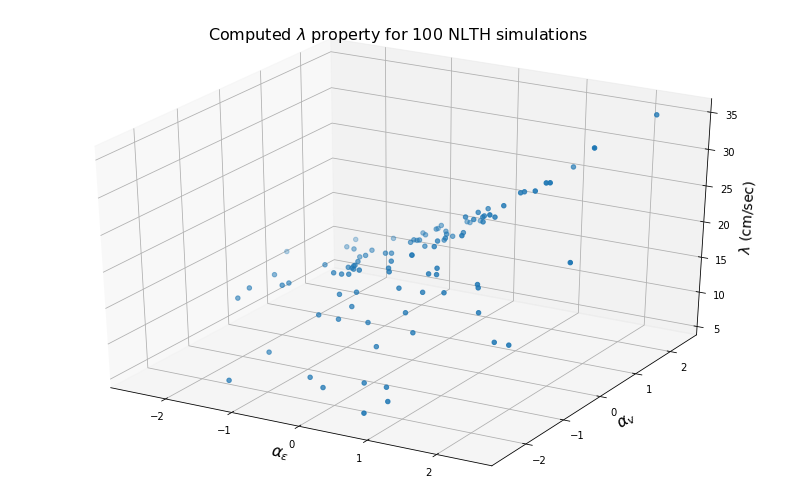

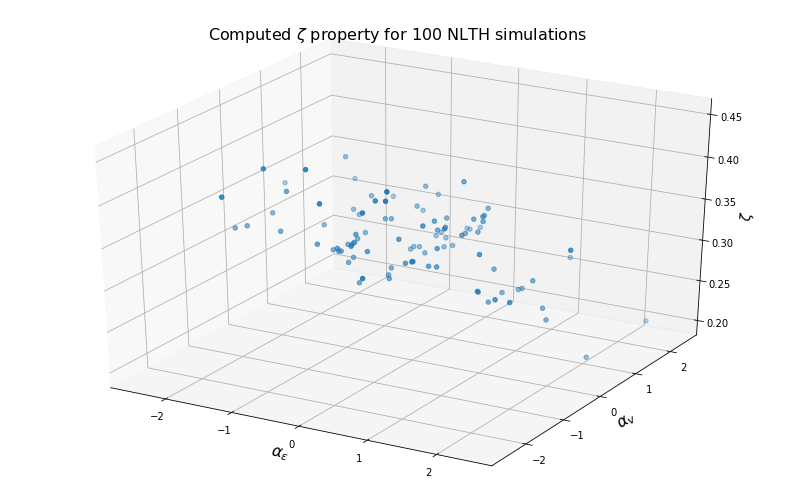

In [ ]:
##pivot_numpy = np.concatenate((np.zeros(9)[:, np.newaxis], pivot_numpy), axis=1)
ecu_100_alpha, Vult_100_alpha = zip(*NLTHA100_pivot.index.values)
ecu_100_alpha, Vult_100_alpha = np.asarray(ecu_100_alpha), np.asarray(Vult_100_alpha)

result_100_list,lambda_100_list,zeta_100_list = [],[],[]

IM = np.arange(0,45,5)
fragility_table_100 = pd.DataFrame(columns = ['0','5','10','15','20','25','30','35','40'])
z_list = []

def frag(lambdazeta):
    estimated_fragility = sp.norm.cdf(np.log(factor_list),np.log(lambdazeta[0]),lambdazeta[1])
    log_likelihood = np.log(sp.binom.pmf(pcllps*nrcrds,nrcrds,estimated_fragility))
    fun = -np.sum(log_likelihood)

    return fun

for i,ecu_i in enumerate(ecu_100_alpha):
    factor_list = np.array([0,5,10,15,20,25,30,35,40])
    ncllps_NLTHA100 = NLTHA100_pivot.iloc[i]
    nrcrds = 12
    pcllps = ncllps_NLTHA100/nrcrds
    # starting guess
    lambdazeta_start = [24,0.4] 
    # Bounds
    bnds = ((4, 50), (0.2, 1))


    result = spo.minimize(frag,lambdazeta_start,options={'disp': True},bounds=bnds)

    if result.success:
        miny = result.x
        lambda_mxlk = round(miny[0],2)
        zeta_mxlk = round(miny[1],2)
        lambda_100_list.append(lambda_mxlk)
        zeta_100_list.append(zeta_mxlk)

        z_mxlk = -round(result.fun,2)
        z_list.append(z_mxlk)
        fragility_table_100.loc[i] = sp.norm.cdf(np.log(IM),np.log(lambda_mxlk),zeta_mxlk)

lambda_100_list = np.array(lambda_100_list)
zeta_100_list = np.array(zeta_100_list)

print(pd.DataFrame({"eps":ecu_100_alpha,"V":Vult_100_alpha,"$lambda$":lambda_100_list,'$zeta$':zeta_100_list,'cost':z_list},index=None))

fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')

# Creating plot
ax.scatter(ecu_100_alpha, Vult_100_alpha, lambda_100_list)
ax.set_zlabel(r"$\lambda$ (cm/sec)",fontsize=14)
ax.set_xlabel(r"$\alpha_\epsilon$",fontsize=16)
ax.set_ylabel(r"$\alpha_v$",fontsize=16)
ax.set_title(r"Computed $\lambda$ property for 100 NLTH simulations",fontsize=16)

fig.show()
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
ax.scatter(ecu_100_alpha, Vult_100_alpha, zeta_100_list)
ax.set_zlabel(r"$\zeta$",fontsize=14)
ax.set_xlabel(r"$\alpha_\epsilon$",fontsize=16)
ax.set_ylabel(r"$\alpha_v$",fontsize=16)
ax.set_title(r"Computed $\zeta$ property for 100 NLTH simulations",fontsize=16)

fig.show()

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log


0.43052890839367114


,0,5,10,15,20,25,30,35,40
0,0.0,4.382175e-03,2.801339e-01,0.729102,0.927335,0.982679,0.995961,0.999039,0.999763
1,0.0,4.382175e-03,2.801339e-01,0.729102,0.927335,0.982679,0.995961,0.999039,0.999763
2,0.0,1.976744e-03,1.995636e-01,0.636592,0.884052,0.967972,0.991531,0.997754,0.999390
3,0.0,1.976744e-03,1.995636e-01,0.636592,0.884052,0.967972,0.991531,0.997754,0.999390
4,0.0,1.976744e-03,1.995636e-01,0.636592,0.884052,0.967972,0.991531,0.997754,0.999390
...,...,...,...,...,...,...,...,...,...
95,0.0,2.428903e-13,4.162906e-06,0.002293,0.046087,0.214336,0.475209,0.710355,0.861823
96,0.0,1.330352e-03,2.211007e-01,0.705219,0.928877,0.985640,0.997244,0.999467,0.999894
97,0.0,1.696356e-22,2.450944e-10,0.000014,0.002921,0.050424,0.232954,0.516592,0.760918
98,0.0,1.696356e-22,2.450944e-10,0.000014,0.002921,0.050424,0.232954,0.516592,0.760918


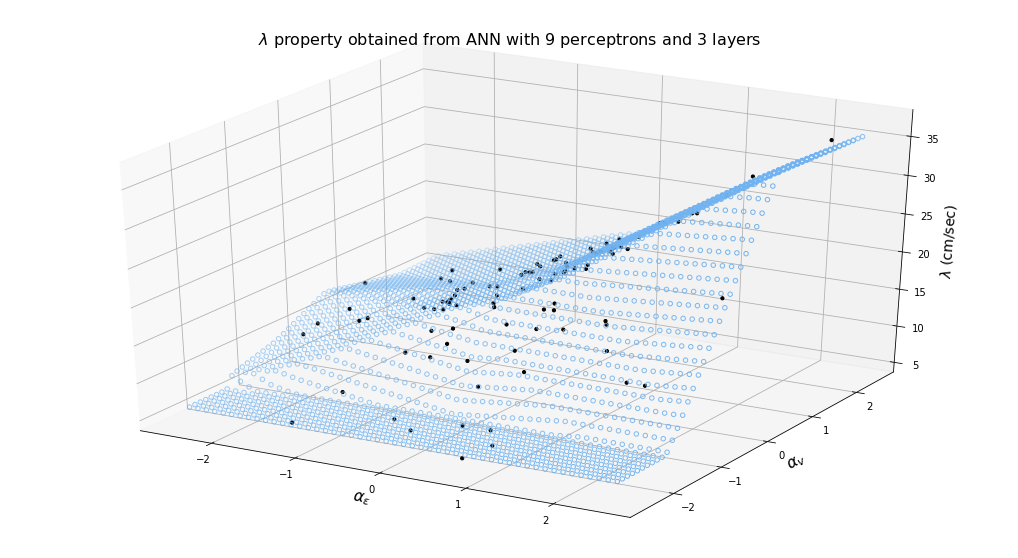

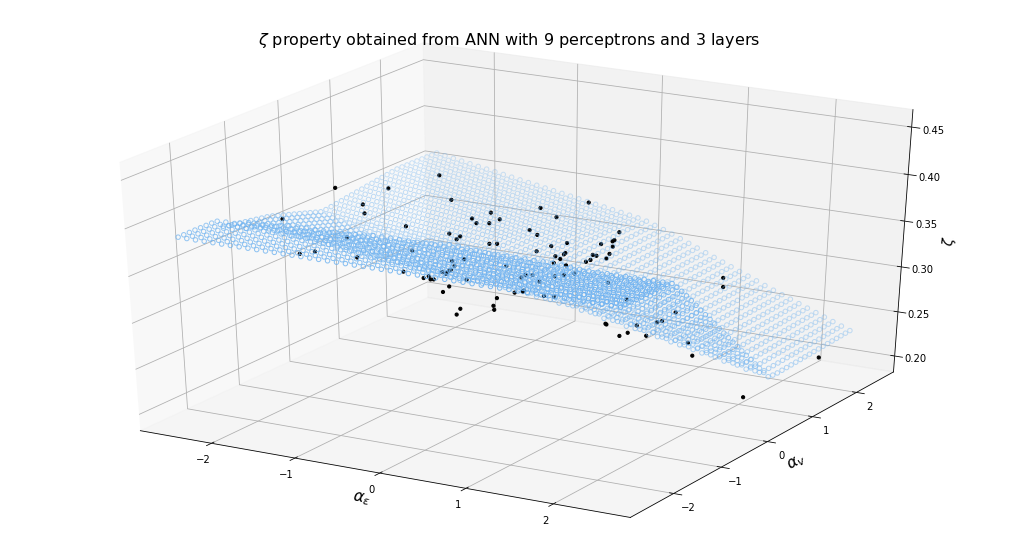

In [ ]:
from sklearn.neural_network import MLPRegressor

ecu_100_alpha, Vult_100_alpha = map(list,zip(*NLTHA100_pivot.index.values))
x_ANN =np.column_stack((ecu_100_alpha,Vult_100_alpha))
y_ANN = np.column_stack((lambda_100_list,zeta_100_list))

X_train, X_test, y_train, y_test = train_test_split(x_ANN, y_ANN, train_size=0.5, test_size=0.2)

regr_ANN = MLPRegressor(hidden_layer_sizes=(9,3),solver='lbfgs', alpha=0.5)
regr_ANN.fit(X_train, y_train)

y_pred_train_m1 = regr_ANN.predict(X_train)
y_pred_test_m1 = regr_ANN.predict(X_test)
y_pred_ANN = regr_ANN.predict(x_ANN)
MSE = mean_squared_error(y_test, y_pred_test_m1, squared=False)
print(MSE)


x1_mesh_ANN,x2_mesh_ANN = np.linspace(-2.5, 2.5, 50), np.linspace(-2.5, 2.5, 50)
x1_mesh_ANN, x2_mesh_ANN = np.meshgrid(x1_mesh_ANN, x2_mesh_ANN)
X_mesh_ANN = np.array([x1_mesh_ANN.flatten(), x2_mesh_ANN.flatten()]).T
y_mesh_ANN = regr_ANN.predict(X_mesh_ANN)

fig, ax = plt.subplots(figsize =(18,10), subplot_kw={'projection': '3d'})
ax.set_zlabel(r"$\lambda$ (cm/sec)",fontsize=14)
ax.set_xlabel(r"$\alpha_\epsilon$",fontsize=16)
ax.set_ylabel(r"$\alpha_v$",fontsize=16)
ax.set_title(r"$\lambda$ property obtained from ANN with 9 perceptrons and 3 layers",fontsize=16)
ax.scatter(x_ANN[:,0], x_ANN[:,1], y_ANN[:,0],color='black',marker='.',alpha=1,s=40)
ax.scatter(x1_mesh_ANN, x2_mesh_ANN, y_mesh_ANN[:,0], facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')

fig, ax = plt.subplots(figsize =(18,10), subplot_kw={'projection': '3d'})
ax.set_zlabel(r"$\zeta$",fontsize=14)
ax.set_xlabel(r"$\alpha_\epsilon$",fontsize=16)
ax.set_ylabel(r"$\alpha_v$",fontsize=16)
ax.set_title(r"$\zeta$ property obtained from ANN with 9 perceptrons and 3 layers",fontsize=16)
ax.scatter(x_ANN[:,0], x_ANN[:,1], y_ANN[:,1],color='black',marker='.',alpha=1,s=40)
ax.scatter(x1_mesh_ANN, x2_mesh_ANN, y_mesh_ANN[:,1], facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')

result_table = pd.DataFrame({'y_act':y_ANN.tolist(),'y_pred':y_pred_ANN.tolist()}).to_excel('ssss.xlsx')

IM = np.arange(0,45,5)
fragility_table_ANN = pd.DataFrame(columns = ['0','5','10','15','20','25','30','35','40'])
z_list = []

for i in np.arange(len(y_ANN)):
  fragility_table_ANN.loc[i] = sp.norm.cdf(np.log(IM),np.log(y_ANN[i,0]),y_ANN[i,1])
fragility_table_ANN


1000 realization for ANN

In [ ]:
alpha_ecu_1000 = np.random.normal(0, 1, 1000)
alpha_Vult_1000 = np.random.normal(0, 1, 1000)

x_1000_ANN = np.array([alpha_ecu_1000, alpha_Vult_1000]).T
y_1000_ANN = regr_ANN.predict(x_1000_ANN)

fragility_table_ANN_1000 = pd.DataFrame(columns = ['0','5','10','15','20','25','30','35','40'])

for i in np.arange(len(y_1000_ANN)):
  fragility_table_ANN_1000.loc[i] = sp.norm.cdf(np.log(IM),np.log(y_1000_ANN[i,0]),y_1000_ANN[i,1])
fragility_table_ANN_1000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while w

,0,5,10,15,20,25,30,35,40
0,0.0,2.505655e-04,7.876934e-02,0.419011,0.743236,0.906365,0.968722,0.989882,0.996737
1,0.0,1.406155e-07,2.477335e-03,0.073592,0.314078,0.604252,0.809510,0.918235,0.967213
2,0.0,1.201914e-15,2.250909e-07,0.000381,0.014841,0.105702,0.310563,0.557438,0.757340
3,0.0,4.823722e-06,1.326674e-02,0.176827,0.495333,0.757622,0.899567,0.961622,0.985915
4,0.0,6.398722e-08,1.693068e-03,0.059992,0.281323,0.570665,0.787149,0.906499,0.961843
...,...,...,...,...,...,...,...,...,...
995,0.0,6.379825e-06,1.510877e-02,0.188865,0.511860,0.769437,0.905723,0.964342,0.987016
996,0.0,3.107039e-06,1.080256e-02,0.159234,0.469906,0.738826,0.889547,0.957122,0.984072
997,0.0,2.044517e-04,7.212735e-02,0.402518,0.730396,0.900033,0.966173,0.988948,0.996408
998,0.0,3.088172e-04,8.618744e-02,0.436403,0.756323,0.912676,0.971221,0.990788,0.997053


In [ ]:
ecu_100_alpha_frag, Vult_100_alpha_frag = zip(*NLTHA100_pivot.index.values)

x_100 = np.array([ecu_100_alpha_frag, Vult_100_alpha_frag]).T
y_100_ANN = regr_ANN.predict(x_100)

fragility_table_ANN_100 = pd.DataFrame(columns = ['0','5','10','15','20','25','30','35','40'])

for i in np.arange(len(y_100_ANN)):
  fragility_table_ANN_100.loc[i] = sp.norm.cdf(np.log(IM),np.log(y_100_ANN[i,0]),y_100_ANN[i,1])

x_100_poly_CCM9_deg2 = deg2_polymodel.fit_transform(x_100)
y_100_CCM9_deg2 = deg2_CCM9_regmodel.predict(x_100_poly_CCM9_deg2)

fragility_table_CCM9_100_deg2 = pd.DataFrame(columns = ['0','5','10','15','20','25','30','35','40'])

for i in np.arange(len(y_100_ANN)):
  fragility_table_CCM9_100_deg2.loc[i] = sp.norm.cdf(np.log(IM),np.log(y_100_CCM9_deg2[i,0]),y_100_CCM9_deg2[i,1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log


,0,5,10,15,20,25,30,35,40
0,0.0,6.088462e-03,2.880218e-01,0.719116,0.917527,0.978083,0.994265,0.998468,0.999576
1,0.0,2.183995e-02,4.526189e-01,0.839223,0.962385,0.991578,0.998070,0.999536,0.999882
2,0.0,2.265780e-03,1.967612e-01,0.620995,0.871200,0.961737,0.989088,0.996880,0.999088
3,0.0,1.235156e-02,3.723875e-01,0.787527,0.944637,0.986558,0.996720,0.999171,0.999780
4,0.0,2.716877e-03,2.113800e-01,0.638966,0.880371,0.965144,0.990207,0.997233,0.999198
...,...,...,...,...,...,...,...,...,...
95,0.0,8.745560e-13,6.455866e-06,0.002659,0.047456,0.210827,0.461926,0.692518,0.846495
96,0.0,4.056352e-03,2.469751e-01,0.678826,0.899598,0.972017,0.992403,0.997911,0.999408
97,0.0,5.945353e-16,1.569322e-07,0.000309,0.013065,0.097886,0.296895,0.543600,0.747415
98,0.0,2.669999e-15,3.386764e-07,0.000483,0.017136,0.115248,0.326644,0.573313,0.768533


In [ ]:

MSE = mean_squared_error(fragility_table_100, fragility_table_ANN_100, squared=False)
r2 = r2_score(fragility_table_100, fragility_table_ANN_100)

y_ANN_residual = (fragility_table_100-fragility_table_ANN_100)
y_CCM9_deg2_residual = (fragility_table_100-fragility_table_CCM9_100_deg2)
y_CCM9_deg3_residual = (fragility_table_100-fragility_table_CCM9_100_deg3)

y_CCM9_deg2_residual

,0,5,10,15,20,25,30,35,40
0,0.0,-0.951223,-0.719621,-0.270895,-0.072665,-0.017321,-0.004039,-0.000961,-0.000237
1,0.0,-0.960208,-0.719658,-0.270895,-0.072665,-0.017321,-0.004039,-0.000961,-0.000237
2,0.0,-0.956505,-0.800327,-0.363408,-0.115948,-0.032028,-0.008469,-0.002246,-0.000610
3,0.0,-0.962130,-0.800272,-0.363407,-0.115948,-0.032028,-0.008469,-0.002246,-0.000610
4,0.0,-0.965727,-0.800244,-0.363406,-0.115948,-0.032028,-0.008469,-0.002246,-0.000610
...,...,...,...,...,...,...,...,...,...
95,0.0,-0.905726,-0.999891,-0.997707,-0.953913,-0.785664,-0.524791,-0.289645,-0.138177
96,0.0,-0.961964,-0.778812,-0.294781,-0.071123,-0.014360,-0.002756,-0.000533,-0.000106
97,0.0,-0.857481,-0.999654,-0.999985,-0.997079,-0.949576,-0.767046,-0.483408,-0.239082
98,0.0,-0.834750,-0.994290,-0.999696,-0.997057,-0.949574,-0.767045,-0.483408,-0.239082


In [ ]:
fragility_table_ANN_1000.median()*12

0      0.000000
5      0.000960
10     0.557021
15     3.892341
20     7.925322
25    10.340126
30    11.392416
35    11.787997
40    11.927143
dtype: float64

In [ ]:

import math
def frag(lambdazeta):
    estimated_fragility = sp.norm.cdf(np.log(factor_list),np.log(lambdazeta[0]),lambdazeta[1])
    log_likelihood = np.log(sp.binom.pmf(ncllps_ANN1000,nrcrds,estimated_fragility))
    fun = -np.sum(log_likelihood)

    return fun

factor_list = np.array([0,5,10,15,20,25,30,35,40])
nrcrds = 12
ncllps_ANN1000 = np.round(fragility_table_ANN_1000.median()*12)
pcllps_ANN1000 = ncllps_ANN1000/12

# starting guess
lambdazeta_start = np.array([15,0.4])

# Bounds
bnds = ((4, 50), (0.2, 1))

result = spo.minimize(frag,lambdazeta_start,options={'disp': True},bounds=bnds)
ANN1000_lgnrml = []
if result.success:
    print("Success!", end = '\n')
    miny = result.x
    ANN1000_lambda = round(miny[0],2)
    ANN1000_zeta = round(miny[1],2)
    ANN1000_cost = -round(result.fun,2)

ANN1000_lz = [ANN1000_lambda,ANN1000_zeta,ANN1000_cost]
ANN1000_lgnrml = sp.norm.cdf(np.log(np.linspace(0,40,1000)),np.log(ANN1000_lz[0]),ANN1000_lz[1])

print(result)

Success!
      fun: 6.505529303188514
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.88178346e-08,  6.21724894e-07])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 39
      nit: 11
     njev: 13
   status: 0
  success: True
        x: array([17.17853007,  0.35589923])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log


0     0.000000
5     0.000080
10    0.046418
15    0.324362
20    0.660444
25    0.861677
30    0.949368
35    0.982333
40    0.993929
dtype: float64

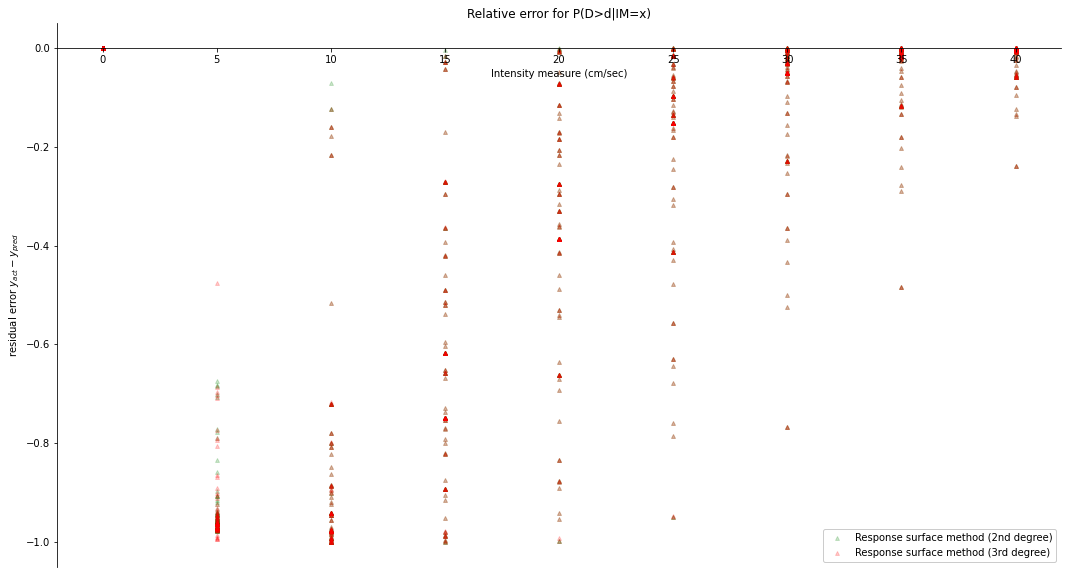

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize =(18,10))

for lbl,clr,rsdl,mrkr in zip(['Response surface method (2nd degree)','Response surface method (3rd degree)'],['green','red'],[y_CCM9_deg2_residual,y_CCM9_deg3_residual],['^','^']):
    for sel_IM in [0,5,10,15,20,25,30,35,40]:
        if sel_IM == 10:
          ax.scatter([sel_IM]*100,rsdl[str(sel_IM)],color=clr,s=15,label=lbl,alpha=0.2,marker=mrkr)
        else:
          ax.scatter([sel_IM]*100,rsdl[str(sel_IM)],color=clr,s=15,alpha=0.2,marker=mrkr)

    #ax.scatter(X_train[:,0],rsdl,color=clr,s=15,label=lbl,alpha=0.7,marker=mrkr)
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_title(r"Relative error for P(D>d|IM=x)")
    ax.set_ylabel(r"residual error $y_{act}-y_{pred}$")
    ax.set_xlabel(r"Intensity measure (cm/sec)")

    ax.legend(loc='best', fancybox=True, framealpha=1)

    print('\n')
# do not forget to make the straight line between 0 and 5


'''

'''
fragility_table_ANN_1000.median()

0     0.000000
5     0.000080
10    0.046418
15    0.324362
20    0.660444
25    0.861677
30    0.949368
35    0.982333
40    0.993929
dtype: float64

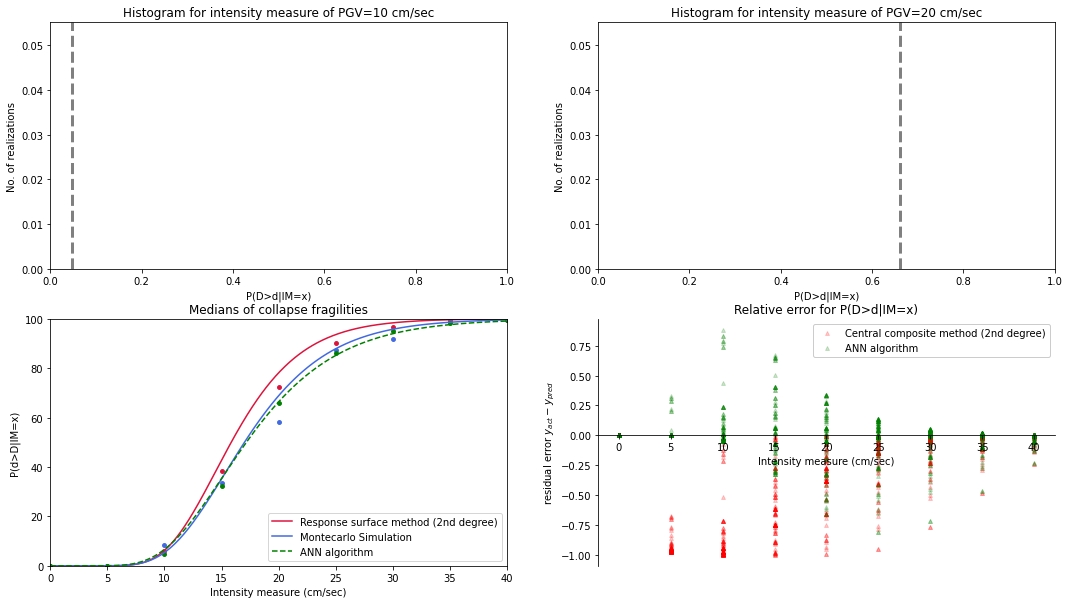

In [ ]:
from scipy.interpolate import interp1d

fig, ax = plt.subplots(nrows=2,ncols=2,figsize =(18,10))
for y,sel_IM in zip([0,1],["10","20"]):
  ax[0,y].hist(fragility_table_ANN_1000[sel_IM],color='silver', edgecolor='k', alpha=0.65,bins=np.arange(min(fragility_table_ANN_1000[sel_IM]), max(fragility_table_ANN_1000[sel_IM]) + 0.1, 0.1))
  ax[0,y].set_xlim(0,1)
  ax[0,y].set_ylim(0)
  ax[0,y].set_xlabel('P(D>d|IM=x)')
  #ax[0,y].set_xticks([np.linspace(0,1.1,0.1)])
  ax[0,y].set_ylabel('No. of realizations')   ## Mean or median???????????????
  ax[0,y].set_title('Histogram for intensity measure of PGV='+str(sel_IM)+' cm/sec') ### Title is not ready
  ax[0,y].axvline(np.median(fragility_table_ANN_1000[sel_IM],axis=0), color='gray', linestyle='dashed', linewidth=3)


        # 1000 points of x,    interpolation for the curve,                                                              clearing non-zeroes
ax[1,0].plot(np.linspace(0,40,1000),CCM9_1000_lgnrml_deg2*100,linestyle='-',color='crimson',label='Response surface method (2nd degree)')
#ax[1,0].plot(np.linspace(0,40,1000),CCM9_1000_lgnrml_deg3*1,linestyle='-',color='green',label='Response surface method (3rd degree)')

ax[1,0].scatter(np.arange(0,45,5),np.median(fragility_table_CCM9_1000_deg2,axis=0)*100/12,s=15,color='crimson')
#ax[1,0].scatter(np.arange(0,45,5),fragility_table_CCM9_1000_deg3.median()*1/12,s=15,color='green')

ax[1,0].plot(np.linspace(0,40,100),NLTHA100_frag*100,linestyle='-',color='royalblue',label='Montecarlo Simulation ')
ax[1,0].scatter(np.arange(0,45,5),NLTHA100_pivot.median()*100/12,s=15,color='royalblue')
#ax[1,0].plot(np.linspace(5,40,1000),make_interp_spline(np.arange(5,45,5),fragility_table_ANN_1000.iloc[:,1:].median())(np.linspace(5,40,1000)).clip(0),dashes=[4, 4],color='green',label='ANN algorithm')
ax[1,0].scatter(np.arange(0,45,5),fragility_table_ANN_1000.median()*100,s=15,color='green')

ax[1,0].plot(np.linspace(0,40,1000),ANN1000_lgnrml*100,linestyle='--',color='green',label='ANN algorithm')

#ANN1000_lgnrml

ax[1,0].legend()

'''
ax[1,0].plot(np.linspace(5,40,1000),make_interp_spline(np.arange(5,45,5),np.median(fragility_table_ANN_1000.iloc[:,1:],axis=0))(np.linspace(5,40,1000)).clip(0),linestyle='--')
ax[1,0].scatter(np.arange(0,45,5),np.median(fragility_table_ANN_1000,axis=0),s=15)
ax[1,0].plot(np.linspace(0,40,1000),make_interp_spline(np.arange(0,45,5),np.median(NLTHA100_pivot,axis=0))(np.linspace(0,40,1000)).clip(0),linestyle='-')
ax[1,0].scatter(np.arange(0,45,5),np.median(NLTHA100_pivot,axis=0),s=15)
ax[1,0].plot(np.linspace(5,40,1000),make_interp_spline(np.arange(5,45,5),np.median(fragility_table_CCM9_1000.iloc[:,1:],axis=0))(np.linspace(5,40,1000)).clip(0),linestyle='--')
ax[1,0].scatter(np.arange(0,45,5),np.median(fragility_table_CCM9_1000,axis=0),s=15)
ax[1,0].plot(np.linspace(5,40,1000),make_interp_spline(np.arange(5,45,5),fragility_table_CCM9_1000.iloc[:,1:].median())(np.linspace(5,40,1000)).clip(0),linestyle='-',color='crimson',label='Central composite method')
ax[1,0].scatter(np.arange(0,45,5),fragility_table_CCM9_1000.median(),s=15,color='crimson')
'''

ax[1,0].set_xlim(0,40)
ax[1,0].set_ylim(0,100)
ax[1,0].set_title('Medians of collapse fragilities')
ax[1,0].set_xlabel('Intensity measure (cm/sec)')
ax[1,0].set_ylabel('P(d>D|IM=x)')
ax[1,0].legend()

######## testing phase ################

## preparing data

for lbl,clr,rsdl,mrkr in zip(['Central composite method (2nd degree)','ANN algorithm'],['red','green'],[y_CCM9_deg2_residual,y_ANN_residual],['^','^']):
    for sel_IM in [0,5,10,15,20,25,30,35,40]:
        if sel_IM == 10:
          ax[1,1].scatter([sel_IM]*100,rsdl[str(sel_IM)],color=clr,s=15,label=lbl,alpha=0.2,marker=mrkr)
        else:
          ax[1,1].scatter([sel_IM]*100,rsdl[str(sel_IM)],color=clr,s=15,alpha=0.2,marker=mrkr)

    #ax[1,1].scatter(X_train[:,0],rsdl,color=clr,s=15,label=lbl,alpha=0.7,marker=mrkr)
    ax[1,1].spines['bottom'].set_position('zero')
    ax[1,1].spines['right'].set_color('none')
    ax[1,1].spines['top'].set_color('none')
    ax[1,1].set_title(r"Relative error for P(D>d|IM=x)")
    ax[1,1].set_ylabel(r"residual error $y_{act}-y_{pred}$")
    ax[1,1].set_xlabel(r"Intensity measure (cm/sec)")

    ax[1,1].legend(loc='best', fancybox=True, framealpha=1)

    print('\n')
# do not forget to make the straight line between 0 and 5


'''

'''
fragility_table_ANN_1000.median()

In [ ]:
for i in np.arange(0,100,1):
    print(y_ANN_residual.iloc[i])

0     0.000000
5    -0.010597
10   -0.040536
15    0.026664
20    0.035010
25    0.019582
30    0.008629
35    0.003496
40    0.001384
Name: 0, dtype: float64
0     0.000000
5     0.001361
10    0.032641
15    0.029102
20    0.011029
25    0.003117
30    0.000795
35    0.000198
40    0.000050
Name: 1, dtype: float64
0     0.000000
5     0.001315
10    0.046107
15    0.034461
20    0.005565
25   -0.001439
30   -0.001288
35   -0.000577
40   -0.000216
Name: 2, dtype: float64
0     0.000000
5    -0.000102
10   -0.019305
15   -0.035788
20   -0.021506
25   -0.008549
30   -0.002869
35   -0.000901
40   -0.000278
Name: 3, dtype: float64
0     0.000000
5    -0.007134
10   -0.039002
15    0.036202
20    0.057857
25    0.038690
30    0.019952
35    0.009313
40    0.004197
Name: 4, dtype: float64
0     0.000000
5    -0.000117
10    0.000972
15    0.004712
20    0.004604
25    0.002810
30    0.001409
35    0.000647
40    0.000286
Name: 5, dtype: float64
0     0.000000
5     0.002868
10    0.046941
1

In [ ]:
######## testing phase ################

## preparing data

fig,ax = plt.subplots(figsize=(18,10))
for lbl,clr,rsdl,mrkr in zip(['Central composite method','ANN'],['red','green'],[y_CCM9_residual,y_ANN_residual],['^','^']):
    for i in np.arange(0,100,1):
        if i == 0:
          ax.scatter([ecu_100_alpha_frag[i]]*9,rsdl.iloc[i],color=clr,s=15,label=lbl,alpha=0.3,marker=mrkr)
        else:
          ax.scatter([ecu_100_alpha_frag[i]]*9,rsdl.iloc[i],color=clr,s=15,alpha=0.2,marker=mrkr)

    #ax.scatter(X_train[:,0],rsdl,color=clr,s=15,label=lbl,alpha=0.7,marker=mrkr)
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_title(r"Relative error for P(D>d|IM=x)")
    ax.set_ylabel(r"residual error $y_{act}-y_{pred}$")
    ax.set_xlabel(r"$\alpha_{ecu}$")

    ax.legend()

    print('\n')

In [ ]:
fig,ax = plt.subplots(figsize=(18,10))
for lbl,clr,rsdl,mrkr in zip(['Central composite method','ANN algorithm'],['red','green'],[y_CCM9_residual,y_ANN_residual],['^','^']):
    for sel_IM in [0,5,10,15,20,25,30,35,40]:
        if sel_IM == 10:
          ax.scatter([sel_IM]*100,rsdl[str(sel_IM)],color=clr,s=15,label=lbl,alpha=0.2,marker=mrkr)
        else:
          ax.scatter([sel_IM]*100,rsdl[str(sel_IM)],color=clr,s=15,alpha=0.2,marker=mrkr)

    #ax.scatter(X_train[:,0],rsdl,color=clr,s=15,label=lbl,alpha=0.7,marker=mrkr)
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_title(r"Relative error for P(D>d|IM=x)")
    ax.set_ylabel(r"residual error $y_{act}-y_{pred}$")
    ax.set_xlabel(r"Intensity measure (cm/sec)")

    ax.legend()

    print('\n')

# **ANN** Method 2

In [ ]:
from sklearn.neural_network import MLPRegressor

ecu_100_alpha, Vult_100_alpha = map(list,zip(*NLTHA100_pivot.index.values))
x_ANN2 =np.column_stack((ecu_9_alpha_frag,Vult_9_alpha_frag))
y_ANN2 = NLTHA9_pivot.values

regr_ANN2 = MLPRegressor(alpha=0.32)
regr_ANN2.fit(x_ANN2, y_ANN2)

y_pred_ANN2 = regr_ANN2.predict(x_ANN2)
MSE = mean_squared_error(y_ANN2, y_pred_ANN2, squared=False)
print(MSE)

x1_mesh_ANN,x2_mesh_ANN = np.linspace(-3, 3, 50), np.linspace(-3, 3, 50)
x1_mesh_ANN, x2_mesh_ANN = np.meshgrid(x1_mesh_ANN, x2_mesh_ANN)
X_mesh_ANN = np.array([x1_mesh_ANN.flatten(), x2_mesh_ANN.flatten()]).T
y_mesh_ANN2 = regr_ANN2.predict(X_mesh_ANN)

IM = np.arange(0,45,5)
fragility_table_ANN2 = pd.DataFrame(y_pred_ANN2,columns = ['0','5','10','15','20','25','30','35','40'])
fragility_table_ANN2

In [ ]:

alpha_ecu_1000 = np.random.normal(0, 1, 1000)
alpha_Vult_1000 = np.random.normal(0, 1, 1000)

x_1000_ANN = np.array([alpha_ecu_1000, alpha_Vult_1000]).T
y_1000_ANN2 = regr_ANN2.predict(x_1000_ANN)

fragility_table_ANN2_1000 = pd.DataFrame(y_1000_ANN2,columns = ['0','5','10','15','20','25','30','35','40'])

In [ ]:
from scipy.interpolate import interp1d

fig, ax = plt.subplots(nrows=2,ncols=2,figsize =(18,10))
for y,sel_IM in zip([0,1],["10","20"]):
  ax[0,y].hist(fragility_table_ANN2_1000[sel_IM],color='silver', edgecolor='k', alpha=0.65,bins=np.arange(min(fragility_table_ANN2_1000[sel_IM]), max(fragility_table_ANN2_1000[sel_IM]) + 0.1, 0.1))
  ax[0,y].set_xlim(0,1)
  ax[0,y].set_ylim(0)
  ax[0,y].set_xlabel('P(D>d|IM=x)')
  #ax[0,y].set_xticks([np.linspace(0,1.1,0.1)])
  ax[0,y].set_ylabel('No. of realizations')   ## Mean or median???????????????
  ax[0,y].set_title('Histogram for intensity measure of PGV='+str(sel_IM)+' cm/sec') ### Title is not ready
  ax[0,y].axvline(np.median(fragility_table_ANN2_1000[sel_IM],axis=0), color='gray', linestyle='dashed', linewidth=3)


        # 1000 points of x,    interpolation for the curve,                                                              clearing non-zeroes
ax[1,0].plot(np.linspace(5,40,1000),make_interp_spline(np.arange(5,45,5),fragility_table_CCM9_1000.iloc[:,1:].median())(np.linspace(5,40,1000)).clip(0),dashes=[6, 2],color='crimson',label='Central composite method')
ax[1,0].scatter(np.arange(0,45,5),fragility_table_CCM9_1000.median(),s=15,color='crimson')
ax[1,0].plot(np.linspace(0,40,100),NLTHA100_frag,linestyle='-',color='royalblue',label='Montecarlo Simulation ')
ax[1,0].scatter(np.arange(0,45,5),NLTHA100_pivot.median(),s=15,color='royalblue')
ax[1,0].plot(np.linspace(5,40,1000),make_interp_spline(np.arange(5,45,5),fragility_table_ANN2_1000.iloc[:,1:].median())(np.linspace(5,40,1000)).clip(0),dashes=[4, 4],color='green',label='ANN algorithm')
ax[1,0].scatter(np.arange(0,45,5),fragility_table_ANN2_1000.median(),s=15,color='green')

ax[1,0].legend()

ax[1,0].set_xlim(0,40)
ax[1,0].set_ylim(0,1)
ax[1,0].set_title('Medians of collapse fragilities')
ax[1,0].set_xlabel('Intensity measure (cm/sec)')
ax[1,0].set_ylabel('P(d>D|IM=x)')
ax[1,0].legend()
# do not forget to make the straight line between 0 and 5


'''

'''
fragility_table_ANN_1000.median()

In [ ]:
data = np.random.normal(0, 1, 100) 

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4), sharey=True)

ax1.set_title('Default violin plot')
ax1.set_ylabel('Observed values')
ax1.violinplot(data,positions=[2])


In [ ]:
import tensorflow as tf

ann = tf.keras.models.Sequential()
# Add the input layer and first hidden layer
ann.add(tf.keras.layers.Dense(units=12, activation='relu', input_shape=X_train.shape))
# Add the second hidden layer
ann.add(tf.keras.layers.Dense(units=8, activation='relu'))
# Add the output layer
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# 4. ANN Second Method 

In [17]:

NLTHA49mesh = pd.read_excel('https://github.com/mtareqsoliman/msthesis/blob/main/Results/NLTHA49mesh.xlsx?raw=true')
                          # ln(x)                                mean(ln(x))                                  stdev(ln(x))
#ecu_9600_alpha = norm.cdf(np.log(-np.array(NLTHA49mesh[['ecu']])), np.log(-np.array(NLTHA49mesh[['ecu']])).mean(), np.log(-np.array(NLTHA49mesh[['ecu']])).std())
#Vult_9600_alpha = norm.cdf(np.log(np.array(NLTHA49mesh[['Vult']])), np.log(np.array(NLTHA49mesh[['Vult']])).mean(),  np.log(np.array(NLTHA49mesh[['Vult']])).std())

#ecu_9600_alpha, Vult_9600_alpha = norm.ppf(ecu_9600_alpha,0,1) , norm.ppf(Vult_9600_alpha,0,1)

NLTHA49mesh.tail(10)

,state,ecu_alpha,Vult_alpha,IM,record,ecu,Vult,Vbmax,ect,ecb,uindex,convergence
4694,0,0.666667,1.333333,5,RSN1605_DUZCE_DZC270,-0.007526,221.374249,56.979491,-0.000405,-0.000673,0,0
4695,0,1.333333,1.333333,5,RSN1605_DUZCE_DZC270,-0.009441,221.374249,54.830463,-0.000403,-0.000671,0,0
4696,0,2.000000,1.333333,5,RSN1605_DUZCE_DZC270,-0.011842,221.374249,52.413490,-0.000401,-0.000675,0,0
4697,0,-2.000000,2.000000,5,RSN1605_DUZCE_DZC270,-0.003040,252.619104,59.268217,-0.000406,-0.000677,0,0
4698,0,-1.333333,2.000000,5,RSN1605_DUZCE_DZC270,-0.003813,252.619104,59.268217,-0.000406,-0.000677,0,0
4699,0,-0.666667,2.000000,5,RSN1605_DUZCE_DZC270,-0.004783,252.619104,59.268217,-0.000406,-0.000677,0,0
4700,0,0.000000,2.000000,5,RSN1605_DUZCE_DZC270,-0.006000,252.619104,59.268217,-0.000406,-0.000677,0,0
4701,0,0.666667,2.000000,5,RSN1605_DUZCE_DZC270,-0.007526,252.619104,56.979491,-0.000405,-0.000673,0,0
4702,0,1.333333,2.000000,5,RSN1605_DUZCE_DZC270,-0.009441,252.619104,54.830463,-0.000403,-0.000671,0,0
4703,0,2.000000,2.000000,5,RSN1605_DUZCE_DZC270,-0.011842,252.619104,52.413490,-0.000401,-0.000675,0,0


In [19]:
NLTHA49mesh_pivot = pd.pivot_table(NLTHA49mesh, values='state', index=['ecu_alpha','Vult_alpha'],columns=['IM'], aggfunc=np.sum)  #merging rows makes more problems so leave them as they are
NLTHA49mesh_pivot.insert(0,0,0)

NLTHA49mesh_pivot

IM                    0   5   10  15  20  25  30  35  40
ecu_alpha Vult_alpha                                    
-2.000000 -2.000000    0   4  10  12  12  12  12  12  12
          -1.333333    0   1   5   9  12  12  12  12  12
          -0.666667    0   0   3   7  10  12  12  12  12
           0.000000    0   0   3   7  10  12  12  12  12
           0.666667    0   0   3   7  10  12  12  12  12
           1.333333    0   0   3   7  10  12  12  12  12
           2.000000    0   0   3   7  10  12  12  12  12
-1.333333 -2.000000    0   4  10  12  12  12  12  12  12
          -1.333333    0   1   5   9  12  12  12  12  12
          -0.666667    0   0   2   5  10  11  12  12  12
           0.000000    0   0   2   5  10  11  12  12  12
           0.666667    0   0   2   5  10  11  12  12  12
           1.333333    0   0   2   5  10  11  12  12  12
           2.000000    0   0   2   5  10  11  12  12  12
-0.666667 -2.000000    0   4  10  12  12  12  12  12  12
          -1.333333    0   1   5   9  12  12  12  12  12
          -0.666667    0   0   1   5   7  11  12  12  12
           0.000000    0   0   1   5   7  11  12  12  12
           0.666667    0   0   1   5   7  11  12  12  12
           1.333333    0   0   1   5   7  11  12  12  12
           2.000000    0   0   1   5   7  11  12  12  12
 0.000000 -2.000000    0   4  10  12  12  12  12  12  12
          -1.333333    0   1   5   9  12  12  12  12  12
          -0.666667    0   0   0   4   7  10  11  12  12
           0.000000    0   0   0   4   7  10  11  12  12
           0.666667    0   0   0   4   7  10  11  12  12
           1.333333    0   0   0   4   7  10  11  12  12
           2.000000    0   0   0   4   7  10  11  12  12
 0.666667 -2.000000    0   4   8  12  12  12  12  12  12
          -1.333333    0   1   5   9  12  12  12  12  12
          -0.666667    0   0   1   4   8  10  11  12  12
           0.000000    0   0   0   1   4   8  10  10  11
           0.666667    0   0   0   1   4   8  10  10  11
           1.333333    0   0   0   1   4   8  10  10  11
           2.000000    0   0   0   1   4   8  10  10  11
 1.333333 -2.000000    0   3   9  12  12  12  12  12  12
          -1.333333    0   1   4   8  12  12  12  12  12
          -0.666667    0   0   1   4   9  10  11  12  12
           0.000000    0   0   0   0   1   5   9  10  10
           0.666667    0   0   0   0   1   5   9  10  10
           1.333333    0   0   0   0   1   5   9  10  10
           2.000000    0   0   0   0   1   5   9  10  10
 2.000000 -2.000000    0   3   8  12  12  12  12  12  12
          -1.333333    0   1   5   8  12  12  12  12  12
          -0.666667    0   0   1   4   9  10  11  12  12
           0.000000    0   0   0   0   0   2   7   8  10
           0.666667    0   0   0   0   0   2   7   8  10
           1.333333    0   0   0   0   0   2   7   8  10
           2.000000    0   0   0   0   0   2   7   8  10

<ipython-input-20-b7d22fe54e81>:12: RuntimeWarning: divide by zero encountered in log
  estimated_fragility = sp.norm.cdf(np.log(factor_list),np.log(lambdazeta[0]),lambdazeta[1])
<ipython-input-20-b7d22fe54e81>:40: RuntimeWarning: divide by zero encountered in log
  fragility_table_49mesh.loc[i] = sp.norm.cdf(np.log(IM),np.log(lambda_mxlk),zeta_mxlk)


         eps         V  $lambda$  $zeta$  cost
0  -2.000000 -2.000000      6.14    0.42 -3.00
1  -2.000000 -1.333333     10.16    0.41 -5.18
2  -2.000000 -0.666667     13.32    0.34 -4.89
3  -2.000000  0.000000     13.32    0.34 -4.89
4  -2.000000  0.666667     13.32    0.34 -4.89
5  -2.000000  1.333333     13.32    0.34 -4.89
6  -2.000000  2.000000     13.32    0.34 -4.89
7  -1.333333 -2.000000      6.14    0.42 -3.00
8  -1.333333 -1.333333     10.16    0.41 -5.18
9  -1.333333 -0.666667     14.88    0.33 -5.58
10 -1.333333  0.000000     14.88    0.33 -5.58
11 -1.333333  0.666667     14.88    0.33 -5.58
12 -1.333333  1.333333     14.88    0.33 -5.58
13 -1.333333  2.000000     14.88    0.33 -5.58
14 -0.666667 -2.000000      6.14    0.42 -3.00
15 -0.666667 -1.333333     10.16    0.41 -5.18
16 -0.666667 -0.666667     16.51    0.32 -6.06
17 -0.666667  0.000000     16.51    0.32 -6.06
18 -0.666667  0.666667     16.51    0.32 -6.06
19 -0.666667  1.333333     16.51    0.32 -6.06
20 -0.666667 

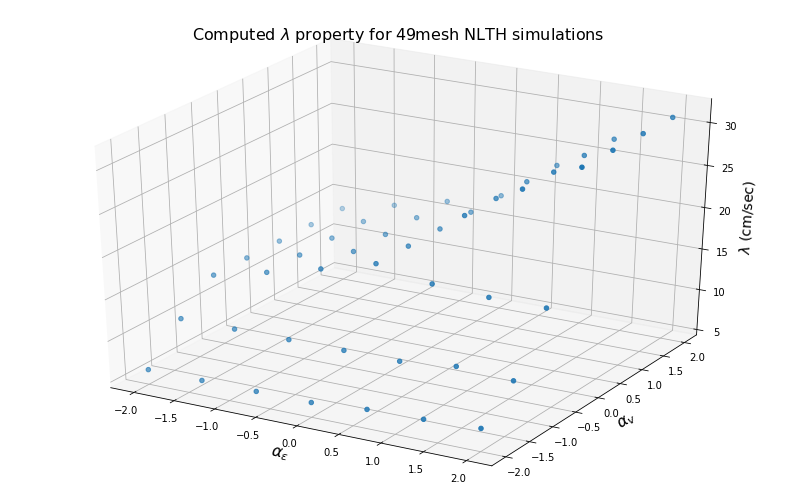

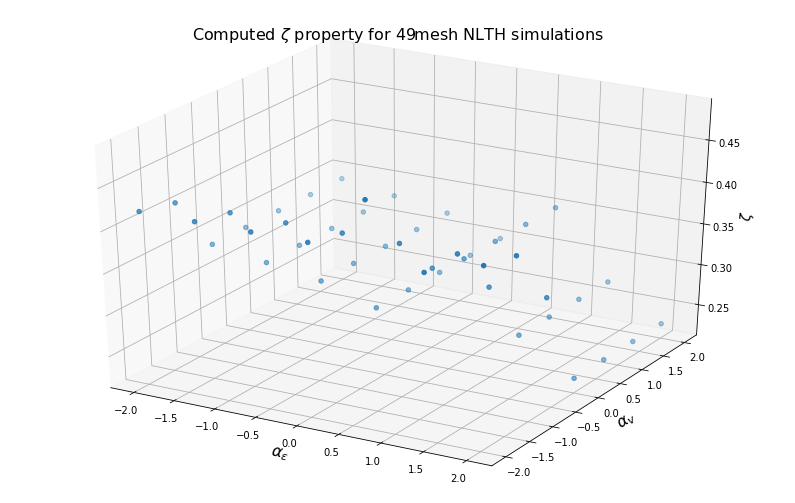

In [20]:
##pivot_numpy = np.concatenate((np.zeros(9)[:, np.newaxis], pivot_numpy), axis=1)
ecu_49mesh_alpha, Vult_49mesh_alpha = zip(*NLTHA49mesh_pivot.index.values)
ecu_49mesh_alpha, Vult_49mesh_alpha = np.asarray(ecu_49mesh_alpha), np.asarray(Vult_49mesh_alpha)

result_49mesh_list,lambda_49mesh_list,zeta_49mesh_list = [],[],[]

IM = np.arange(0,45,5)
fragility_table_49mesh = pd.DataFrame(columns = ['0','5','10','15','20','25','30','35','40'])
z_list = []

def frag(lambdazeta):
    estimated_fragility = sp.norm.cdf(np.log(factor_list),np.log(lambdazeta[0]),lambdazeta[1])
    log_likelihood = np.log(sp.binom.pmf(pcllps*nrcrds,nrcrds,estimated_fragility))
    fun = -np.sum(log_likelihood)

    return fun

for i,ecu_i in enumerate(ecu_49mesh_alpha):
    factor_list = np.array([0,5,10,15,20,25,30,35,40])
    ncllps_NLTHA49mesh = NLTHA49mesh_pivot.iloc[i]
    nrcrds = 12
    pcllps = ncllps_NLTHA49mesh/nrcrds
    # starting guess
    lambdazeta_start = [24,0.4] 
    # Bounds
    bnds = ((4, 50), (0.2, 1))


    result = spo.minimize(frag,lambdazeta_start,options={'disp': True},bounds=bnds)

    if result.success:
        miny = result.x
        lambda_mxlk = round(miny[0],2)
        zeta_mxlk = round(miny[1],2)
        lambda_49mesh_list.append(lambda_mxlk)
        zeta_49mesh_list.append(zeta_mxlk)

        z_mxlk = -round(result.fun,2)
        z_list.append(z_mxlk)
        fragility_table_49mesh.loc[i] = sp.norm.cdf(np.log(IM),np.log(lambda_mxlk),zeta_mxlk)

lambda_49mesh_list = np.array(lambda_49mesh_list)
zeta_49mesh_list = np.array(zeta_49mesh_list)

print(pd.DataFrame({"eps":ecu_49mesh_alpha,"V":Vult_49mesh_alpha,"$lambda$":lambda_49mesh_list,'$zeta$':zeta_49mesh_list,'cost':z_list},index=None))

fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')

# Creating plot
ax.scatter(ecu_49mesh_alpha, Vult_49mesh_alpha, lambda_49mesh_list)
ax.set_zlabel(r"$\lambda$ (cm/sec)",fontsize=14)
ax.set_xlabel(r"$\alpha_\epsilon$",fontsize=16)
ax.set_ylabel(r"$\alpha_v$",fontsize=16)
ax.set_title(r"Computed $\lambda$ property for 49 mesh NLTH simulations",fontsize=16)

fig.show()
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
ax.scatter(ecu_49mesh_alpha, Vult_49mesh_alpha, zeta_49mesh_list)
ax.set_zlabel(r"$\zeta$",fontsize=14)
ax.set_xlabel(r"$\alpha_\epsilon$",fontsize=16)
ax.set_ylabel(r"$\alpha_v$",fontsize=16)
ax.set_title(r"Computed $\zeta$ property for 49 mesh NLTH simulations",fontsize=16)

fig.show()

0.039321849352404695


<ipython-input-37-312f6bcf5561>:46: RuntimeWarning: divide by zero encountered in log
  fragility_table_ANN_mesh.loc[i] = sp.norm.cdf(np.log(IM),y_ANN_mesh[i,0],y_ANN_mesh[i,1])


,0,5,10,15,20,25,30,35,40
0,0.0,3.124151e-01,8.772470e-01,0.983279,0.997536,0.999586,0.999921,0.999983,0.999996
1,0.0,4.187607e-02,4.845586e-01,0.829001,0.950721,0.985959,0.995865,0.998723,0.999585
2,0.0,1.976744e-03,1.995636e-01,0.636592,0.884052,0.967972,0.991531,0.997754,0.999390
3,0.0,1.976744e-03,1.995636e-01,0.636592,0.884052,0.967972,0.991531,0.997754,0.999390
4,0.0,1.976744e-03,1.995636e-01,0.636592,0.884052,0.967972,0.991531,0.997754,0.999390
5,0.0,1.976744e-03,1.995636e-01,0.636592,0.884052,0.967972,0.991531,0.997754,0.999390
6,0.0,1.976744e-03,1.995636e-01,0.636592,0.884052,0.967972,0.991531,0.997754,0.999390
7,0.0,3.124151e-01,8.772470e-01,0.983279,0.997536,0.999586,0.999921,0.999983,0.999996
8,0.0,4.187607e-02,4.845586e-01,0.829001,0.950721,0.985959,0.995865,0.998723,0.999585
9,0.0,4.752409e-04,1.142287e-01,0.509709,0.814901,0.942059,0.983198,0.995228,0.998635


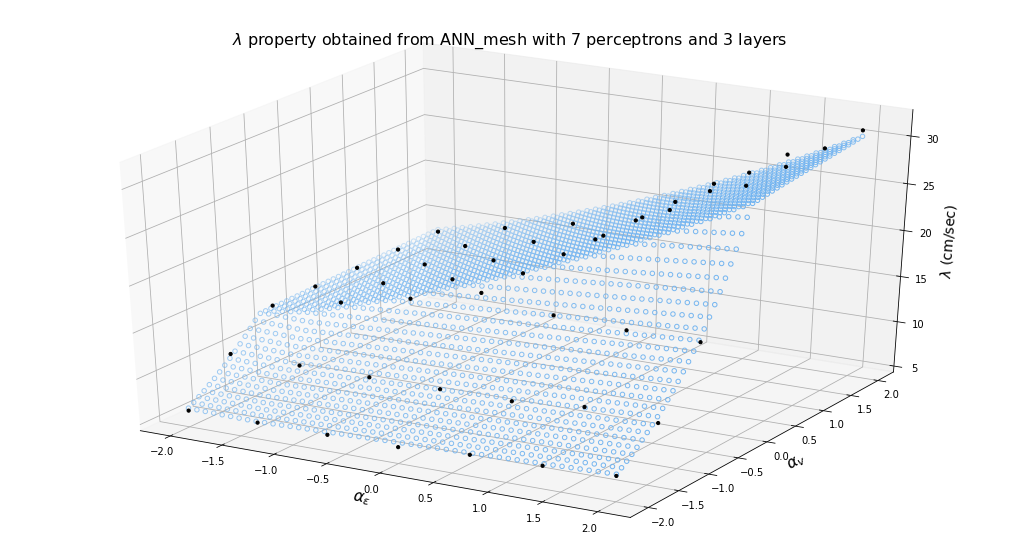

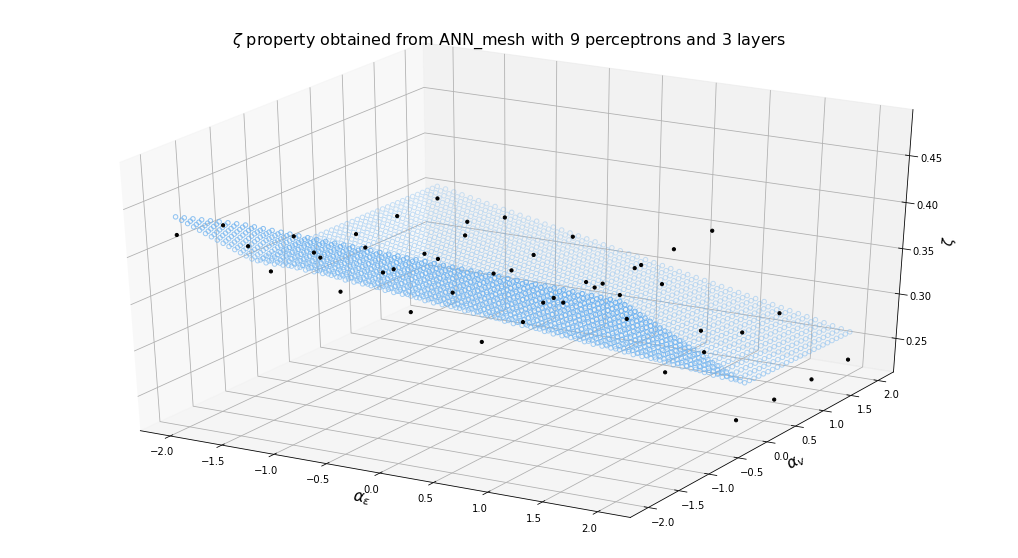

In [37]:
from sklearn.neural_network import MLPRegressor

ecu_49mesh_alpha, Vult_49mesh_alpha = map(list,zip(*NLTHA49mesh_pivot.index.values))
x_ANN_mesh =np.column_stack((ecu_49mesh_alpha,Vult_49mesh_alpha))
y_ANN_mesh = np.column_stack((np.log(lambda_49mesh_list),zeta_49mesh_list))

nprcptrns = 7
nlyrs = 3

regr_ANN_mesh = MLPRegressor(hidden_layer_sizes=(7,3),solver='lbfgs', alpha=0.5)
regr_ANN_mesh.fit(x_ANN_mesh, y_ANN_mesh)

y_pred_ANN_mesh = regr_ANN_mesh.predict(x_ANN_mesh)
MSE = mean_squared_error(y_ANN_mesh, y_pred_ANN_mesh, squared=False)
print(MSE)


x1_mesh_ANN_mesh,x2_mesh_ANN_mesh = np.linspace(-2, 2, 50), np.linspace(-2, 2, 50)
x1_mesh_ANN_mesh, x2_mesh_ANN_mesh = np.meshgrid(x1_mesh_ANN_mesh, x2_mesh_ANN_mesh)
X_mesh_ANN_mesh = np.array([x1_mesh_ANN_mesh.flatten(), x2_mesh_ANN_mesh.flatten()]).T
y_mesh_ANN_mesh = regr_ANN_mesh.predict(X_mesh_ANN_mesh)

fig, ax = plt.subplots(figsize =(18,10), subplot_kw={'projection': '3d'})
ax.set_zlabel(r"$\lambda$ (cm/sec)",fontsize=14)
ax.set_xlabel(r"$\alpha_\epsilon$",fontsize=16)
ax.set_ylabel(r"$\alpha_v$",fontsize=16)
ax.set_title(r"$\lambda$ property obtained from ANN_mesh with "+str(nprcptrns)+" perceptrons and "+str(nlyrs)+" layers",fontsize=16)
ax.scatter(x_ANN_mesh[:,0], x_ANN_mesh[:,1], np.exp(y_ANN_mesh[:,0]),color='black',marker='.',alpha=1,s=40)
ax.scatter(x1_mesh_ANN_mesh, x2_mesh_ANN_mesh, np.exp(y_mesh_ANN_mesh[:,0]), facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')

fig, ax = plt.subplots(figsize =(18,10), subplot_kw={'projection': '3d'})
ax.set_zlabel(r"$\zeta$",fontsize=14)
ax.set_xlabel(r"$\alpha_\epsilon$",fontsize=16)
ax.set_ylabel(r"$\alpha_v$",fontsize=16)
ax.set_title(r"$\zeta$ property obtained from ANN_mesh with 9 perceptrons and 3 layers",fontsize=16)
ax.scatter(x_ANN_mesh[:,0], x_ANN_mesh[:,1], y_ANN_mesh[:,1],color='black',marker='.',alpha=1,s=40)
ax.scatter(x1_mesh_ANN_mesh, x2_mesh_ANN_mesh, y_mesh_ANN_mesh[:,1], facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')

result_table = pd.DataFrame({'y_act':y_ANN_mesh.tolist(),'y_pred':y_pred_ANN_mesh.tolist()}).to_excel('ssss.xlsx')

IM = np.arange(0,45,5)
fragility_table_ANN_mesh = pd.DataFrame(columns = ['0','5','10','15','20','25','30','35','40'])
z_list = []

for i in np.arange(len(y_ANN_mesh)):
  fragility_table_ANN_mesh.loc[i] = sp.norm.cdf(np.log(IM),y_ANN_mesh[i,0],y_ANN_mesh[i,1])
fragility_table_ANN_mesh


In [47]:
alpha_ecu_1000_mesh = np.random.normal(0, 1, 1000)
alpha_Vult_1000_mesh = np.random.normal(0, 1, 1000)

x_1000_ANN_mesh = np.array([alpha_ecu_1000_mesh, alpha_Vult_1000_mesh]).T
y_1000_ANN_mesh = regr_ANN_mesh.predict(x_1000_ANN_mesh)

fragility_table_ANN_1000_mesh = pd.DataFrame(columns = ['0','5','10','15','20','25','30','35','40'])

for i in np.arange(len(y_1000_ANN_mesh)):
  fragility_table_ANN_1000_mesh.loc[i] = sp.norm.cdf(np.log(IM),y_1000_ANN_mesh[i,0],y_1000_ANN_mesh[i,1])

fragility_table_ANN_1000_mesh

,0,5,10,15,20,25,30,35,40
0,0.0,2.368243e-05,0.028977,0.265859,0.608790,0.835334,0.939048,0.978817,0.992825
1,0.0,1.112431e-04,0.056679,0.363262,0.700365,0.885765,0.960709,0.987058,0.995783
2,0.0,9.222667e-04,0.134857,0.528829,0.817729,0.939904,0.981365,0.994295,0.998234
3,0.0,2.712928e-06,0.010891,0.164539,0.483764,0.753246,0.899283,0.962350,0.986542
4,0.0,7.095363e-02,0.603771,0.899055,0.976977,0.994652,0.998685,0.999655,0.999903
...,...,...,...,...,...,...,...,...,...
995,0.0,3.007698e-04,0.085848,0.436707,0.757216,0.913382,0.971598,0.990957,0.997123
996,0.0,9.367216e-06,0.019157,0.217729,0.554291,0.801593,0.923368,0.972517,0.990474
997,0.0,8.610627e-02,0.636563,0.911837,0.980477,0.995547,0.998917,0.999717,0.999921
998,0.0,1.299193e-09,0.000267,0.022463,0.165759,0.432976,0.686762,0.851040,0.935868


In [61]:
ecu_100_alpha_frag, Vult_100_alpha_frag = zip(*NLTHA100_pivot.index.values)

x_100 = np.array([ecu_100_alpha_frag, Vult_100_alpha_frag]).T
y_100_ANN_mesh = regr_ANN_mesh.predict(x_100)

fragility_table_ANN_mesh_100 = pd.DataFrame(columns = ['0','5','10','15','20','25','30','35','40'])

for i in np.arange(len(y_100_ANN_mesh)):
  fragility_table_ANN_mesh_100.loc[i] = sp.norm.cdf(np.log(IM),y_100_ANN_mesh[i,0],y_100_ANN_mesh[i,1])

x_100_poly_CCM9_deg2 = deg2_polymodel.fit_transform(x_100)
y_100_CCM9_deg2 = deg2_CCM9_regmodel.predict(x_100_poly_CCM9_deg2)

fragility_table_CCM9_100_deg2 = pd.DataFrame(columns = ['0','5','10','15','20','25','30','35','40'])

for i in np.arange(len(y_100_ANN_mesh)):
  fragility_table_CCM9_100_deg2.loc[i] = sp.norm.cdf(np.log(IM),y_100_CCM9_deg2[i,0],y_100_CCM9_deg2[i,1])

print("Fragility Table for RSM 100 Analyses")
fragility_table_CCM9_100_deg2.head()

print("Fragility Table for ANN mesh method 100 Analyses")
fragility_table_ANN_mesh_100


Fragility Table for RSM 100 Analyses
Fragility Table for ANN mesh method 100 Analyses


,0,5,10,15,20,25,30,35,40
0,0.0,5.081316e-03,0.257239,0.680926,0.897330,0.970221,0.991545,0.997563,0.999276
1,0.0,8.724305e-03,0.311535,0.729569,0.918358,0.977311,0.993740,0.998230,0.999480
2,0.0,3.078500e-03,0.214078,0.635532,0.875872,0.962574,0.989090,0.996799,0.999037
3,0.0,3.459579e-03,0.223537,0.646083,0.881021,0.964445,0.989698,0.996990,0.999097
4,0.0,1.653996e-03,0.169279,0.579858,0.846972,0.951656,0.985448,0.995636,0.998668
...,...,...,...,...,...,...,...,...,...
95,0.0,1.411268e-10,0.000086,0.011800,0.114212,0.350896,0.613454,0.803961,0.911085
96,0.0,1.387052e-03,0.158269,0.564563,0.838552,0.948365,0.984328,0.995274,0.998552
97,0.0,2.166826e-12,0.000010,0.003311,0.053410,0.224399,0.476618,0.702693,0.851744
98,0.0,2.159089e-13,0.000003,0.001595,0.034103,0.170810,0.405963,0.642413,0.812496


In [82]:
y_ANN_residual = (fragility_table_100-fragility_table_ANN_mesh_100)
y_CCM9_deg2_residual = (fragility_table_100-fragility_table_CCM9_100_deg2)

y_ANN_residual

,0,5,10,15,20,25,30,35,40
0,0.0,-6.991410e-04,0.022895,0.048177,0.030005,0.012458,0.004416,0.001476,0.000487
1,0.0,-4.342130e-03,-0.031401,-0.000466,0.008977,0.005368,0.002221,0.000810,0.000282
2,0.0,-1.101756e-03,-0.014514,0.001060,0.008179,0.005398,0.002440,0.000955,0.000353
3,0.0,-1.482835e-03,-0.023974,-0.009491,0.003030,0.003527,0.001832,0.000764,0.000293
4,0.0,3.227478e-04,0.030284,0.056734,0.037080,0.016316,0.006082,0.002118,0.000722
...,...,...,...,...,...,...,...,...,...
95,0.0,-1.408839e-10,-0.000082,-0.009508,-0.068125,-0.136560,-0.138245,-0.093607,-0.049262
96,0.0,-5.669999e-05,0.062832,0.140656,0.090325,0.037275,0.012916,0.004193,0.001341
97,0.0,-2.166826e-12,-0.000010,-0.003298,-0.050488,-0.173975,-0.243663,-0.186102,-0.090826
98,0.0,-2.159089e-13,-0.000003,-0.001582,-0.031182,-0.120387,-0.173009,-0.125821,-0.051578


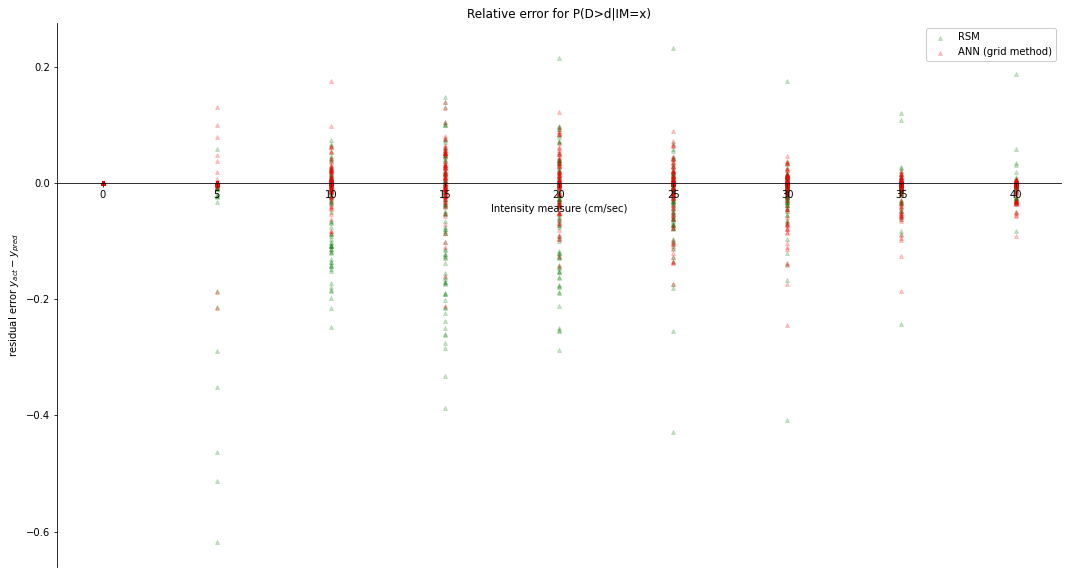

In [84]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize =(18,10))

for lbl,clr,rsdl,mrkr in zip(['RSM','ANN (grid method)'],['green','red'],[y_CCM9_deg2_residual,y_ANN_residual],['^','^']):
    for sel_IM in [0,5,10,15,20,25,30,35,40]:
        if sel_IM == 10:
          ax.scatter([sel_IM]*100,rsdl[str(sel_IM)],color=clr,s=15,label=lbl,alpha=0.2,marker=mrkr)
        else:
          ax.scatter([sel_IM]*100,rsdl[str(sel_IM)],color=clr,s=15,alpha=0.2,marker=mrkr)

    #ax.scatter(X_train[:,0],rsdl,color=clr,s=15,label=lbl,alpha=0.7,marker=mrkr)
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_title(r"Relative error for P(D>d|IM=x)")
    ax.set_ylabel(r"residual error $y_{act}-y_{pred}$")
    ax.set_xlabel(r"Intensity measure (cm/sec)")

    ax.legend(loc='best', fancybox=True, framealpha=1)

    print('\n')
# do not forget to make the straight line between 0 and 5


In [88]:
import math
def frag(lambdazeta):
    estimated_fragility = sp.norm.cdf(np.log(factor_list),np.log(lambdazeta[0]),lambdazeta[1])
    log_likelihood = np.log(sp.binom.pmf(ncllps_ANN1000_mesh,nrcrds,estimated_fragility))
    fun = -np.sum(log_likelihood)

    return fun

factor_list = np.array([0,5,10,15,20,25,30,35,40])
nrcrds = 12
ncllps_ANN1000_mesh = np.round(fragility_table_ANN_1000_mesh.median()*12)
pcllps_ANN1000 = ncllps_ANN1000_mesh/12

# starting guess
lambdazeta_start = np.array([15,0.4])

# Bounds
bnds = ((4, 50), (0.2, 1))

result = spo.minimize(frag,lambdazeta_start,options={'disp': True},bounds=bnds)
ANN1000_mesh_lgnrml = []
if result.success:
    print("Success!", end = '\n')
    miny = result.x
    ANN1000_mesh_lambda = round(miny[0],2)
    ANN1000_mesh_zeta = round(miny[1],2)
    ANN1000_mesh_cost = -round(result.fun,2)

ANN1000_mesh_lz = [ANN1000_mesh_lambda,ANN1000_mesh_zeta,ANN1000_mesh_cost]
ANN1000_mesh_lgnrml = sp.norm.cdf(np.log(np.linspace(0,40,1000)),np.log(ANN1000_mesh_lz[0]),ANN1000_mesh_lz[1])

print(result)

Success!
      fun: 6.505529303188514
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.88178346e-08,  6.21724894e-07])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 39
      nit: 11
     njev: 13
   status: 0
  success: True
        x: array([17.17853007,  0.35589923])


0     0.000000
5     0.000057
10    0.042581
15    0.318575
20    0.660953
25    0.864961
30    0.952031
35    0.983824
40    0.994639
dtype: float64

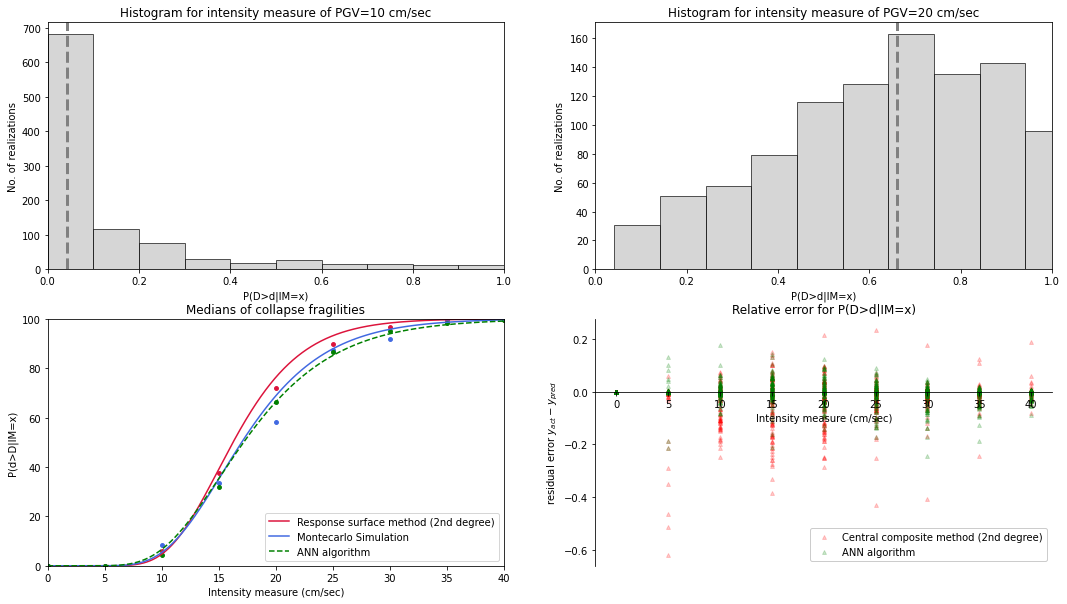

In [89]:
from scipy.interpolate import interp1d

fig, ax = plt.subplots(nrows=2,ncols=2,figsize =(18,10))
for y,sel_IM in zip([0,1],["10","20"]):
  ax[0,y].hist(fragility_table_ANN_1000_mesh[sel_IM],color='silver', edgecolor='k', alpha=0.65,bins=np.arange(min(fragility_table_ANN_1000_mesh[sel_IM]), max(fragility_table_ANN_1000_mesh[sel_IM]) + 0.1, 0.1))
  ax[0,y].set_xlim(0,1)
  ax[0,y].set_ylim(0)
  ax[0,y].set_xlabel('P(D>d|IM=x)')
  #ax[0,y].set_xticks([np.linspace(0,1.1,0.1)])
  ax[0,y].set_ylabel('No. of realizations')   ## Mean or median???????????????
  ax[0,y].set_title('Histogram for intensity measure of PGV='+str(sel_IM)+' cm/sec') ### Title is not ready
  ax[0,y].axvline(np.median(fragility_table_ANN_1000_mesh[sel_IM],axis=0), color='gray', linestyle='dashed', linewidth=3)


        # 1000 points of x,    interpolation for the curve,                                                              clearing non-zeroes
ax[1,0].plot(np.linspace(0,40,1000),CCM9_1000_lgnrml_deg2*100,linestyle='-',color='crimson',label='Response surface method (2nd degree)')
#ax[1,0].plot(np.linspace(0,40,1000),CCM9_1000_lgnrml_deg3*1,linestyle='-',color='green',label='Response surface method (3rd degree)')

ax[1,0].scatter(np.arange(0,45,5),np.median(fragility_table_CCM9_1000_deg2,axis=0)*100/12,s=15,color='crimson')
#ax[1,0].scatter(np.arange(0,45,5),fragility_table_CCM9_1000_deg3.median()*1/12,s=15,color='green')

ax[1,0].plot(np.linspace(0,40,100),NLTHA100_frag*100,linestyle='-',color='royalblue',label='Montecarlo Simulation ')
ax[1,0].scatter(np.arange(0,45,5),NLTHA100_pivot.median()*100/12,s=15,color='royalblue')
#ax[1,0].plot(np.linspace(5,40,1000),make_interp_spline(np.arange(5,45,5),fragility_table_ANN_1000_mesh.iloc[:,1:].median())(np.linspace(5,40,1000)).clip(0),dashes=[4, 4],color='green',label='ANN algorithm')
ax[1,0].scatter(np.arange(0,45,5),fragility_table_ANN_1000_mesh.median()*100,s=15,color='green')

ax[1,0].plot(np.linspace(0,40,1000),ANN1000_mesh_lgnrml*100,linestyle='--',color='green',label='ANN algorithm')

#ANN1000_lgnrml

ax[1,0].legend()

'''
ax[1,0].plot(np.linspace(5,40,1000),make_interp_spline(np.arange(5,45,5),np.median(fragility_table_ANN_1000_mesh.iloc[:,1:],axis=0))(np.linspace(5,40,1000)).clip(0),linestyle='--')
ax[1,0].scatter(np.arange(0,45,5),np.median(fragility_table_ANN_1000_mesh,axis=0),s=15)
ax[1,0].plot(np.linspace(0,40,1000),make_interp_spline(np.arange(0,45,5),np.median(NLTHA100_pivot,axis=0))(np.linspace(0,40,1000)).clip(0),linestyle='-')
ax[1,0].scatter(np.arange(0,45,5),np.median(NLTHA100_pivot,axis=0),s=15)
ax[1,0].plot(np.linspace(5,40,1000),make_interp_spline(np.arange(5,45,5),np.median(fragility_table_CCM9_1000.iloc[:,1:],axis=0))(np.linspace(5,40,1000)).clip(0),linestyle='--')
ax[1,0].scatter(np.arange(0,45,5),np.median(fragility_table_CCM9_1000,axis=0),s=15)
ax[1,0].plot(np.linspace(5,40,1000),make_interp_spline(np.arange(5,45,5),fragility_table_CCM9_1000.iloc[:,1:].median())(np.linspace(5,40,1000)).clip(0),linestyle='-',color='crimson',label='Central composite method')
ax[1,0].scatter(np.arange(0,45,5),fragility_table_CCM9_1000.median(),s=15,color='crimson')
'''

ax[1,0].set_xlim(0,40)
ax[1,0].set_ylim(0,100)
ax[1,0].set_title('Medians of collapse fragilities')
ax[1,0].set_xlabel('Intensity measure (cm/sec)')
ax[1,0].set_ylabel('P(d>D|IM=x)')
ax[1,0].legend()

######## testing phase ################

## preparing data

for lbl,clr,rsdl,mrkr in zip(['Central composite method (2nd degree)','ANN algorithm'],['red','green'],[y_CCM9_deg2_residual,y_ANN_residual],['^','^']):
    for sel_IM in [0,5,10,15,20,25,30,35,40]:
        if sel_IM == 10:
          ax[1,1].scatter([sel_IM]*100,rsdl[str(sel_IM)],color=clr,s=15,label=lbl,alpha=0.2,marker=mrkr)
        else:
          ax[1,1].scatter([sel_IM]*100,rsdl[str(sel_IM)],color=clr,s=15,alpha=0.2,marker=mrkr)

    #ax[1,1].scatter(X_train[:,0],rsdl,color=clr,s=15,label=lbl,alpha=0.7,marker=mrkr)
    ax[1,1].spines['bottom'].set_position('zero')
    ax[1,1].spines['right'].set_color('none')
    ax[1,1].spines['top'].set_color('none')
    ax[1,1].set_title(r"Relative error for P(D>d|IM=x)")
    ax[1,1].set_ylabel(r"residual error $y_{act}-y_{pred}$")
    ax[1,1].set_xlabel(r"Intensity measure (cm/sec)")

    ax[1,1].legend(loc='best', fancybox=True, framealpha=1)

    print('\n')
# do not forget to make the straight line between 0 and 5


'''

'''
fragility_table_ANN_1000_mesh.median()